# Libraries

In [1]:
import psutil
psutil.virtual_memory() 

svmem(total=540408942592, available=518707855360, percent=4.0, used=18275430400, free=519873740800, active=740675584, inactive=10254925824, buffers=3805184, cached=2255966208, shared=211988480, slab=1468575744)

In [2]:
from datetime import datetime

import numpy as np
import pandas as pd
from numpy import array

from os import listdir
from os.path import isfile, join
import glob

import pickle

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
#import cmocean
##from mpl_toolkits.basemap import Basemap

from matplotlib import ticker
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D
from cartopy.mpl.ticker import LongitudeFormatter


import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
from scipy.ndimage import gaussian_filter
import xarray as xr
import scipy as _sp

In [3]:
import klus.algorithms as al
# import d3s.domain as domain
import klus.kernels as kernels
# import d3s.tools as tools

import zapata.computation as zcom
import zapata.data as zdat
import zapata.lib as zlib
import zapata.mapping as zmap
import zapata.koopman as zkop

from scipy.spatial import distance

from scipy.signal import argrelextrema
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

#%pdb
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [4]:
import scipy.linalg as sc
import numpy.linalg as lin

# Definition of functions

## Definition order_w

In [4]:
def order_w(w,option='magnitude',direction='up'):
    '''
    Order Eigenvalues according to 
    option
    'magnitude'         abs(w)
    'frequency'         w.imag
    'growth'            w.real
    'ones'              abs(w) closest to 1.0
    
    direction
    'up'               descending
    'down'             ascending
    
    '''
    print(' Ordering Eigenvalues as ', option, ' with direction ',direction)
    w_cont = np.log(w)
    if option == 'magnitude':
        ind=abs(w).argsort()
    elif option == 'frequency':
        ind=abs(w_cont.imag).argsort()
    elif option == 'growth':
        ind=np.abs(w_cont.real - 0.0).argsort()
    elif option == 'one':
        ind=np.abs(np.abs(w) - 1.0).argsort()
    else:
        print(' Error in oder_w', option, direction)
# Choose direction
    if direction == 'up':
        indu=ind[::-1]
    else:
        indu=ind

    w0=w[indu]
    w1=w_cont[indu]
    return w0,w1,indu


## Definition function evolve and verify

In [6]:
def evolve(tim_level,tstep,init_date):
    #tim_level=[0,1,2,3,4,5,6]
    #cases =  216,228,240, 36,48,60,  360,372,384
    #tstep=3
    #nstart=360
    x0=PsiX[:,init_date]
    ht=np.zeros([x0.shape[0],len(tim_level)],dtype='complex')
    for j in tim_level:
        D = np.diag(vw_s[:nmode]**(j*tstep))                  # w --> vw_s
        ht[:,j]=alpha@D@vcut.T@Gxx[init_date,:] 
    return ht

#verify to EOF expansion  (spatial correlation)
def verify(tim_level,tstep,init_date,PCs,ht,verbose=False):
    sstcor=np.zeros([len(tim_level)])
    sstlab=np.zeros([len(tim_level)],dtype='int')
    for neig in range(len(tim_level)):
        kaz1=ht[:,neig].real 
        kaz2=PCs[:,int(init_date+neig*tstep)]
        ytmp = np.expand_dims(udat_tot[:,0:nEOF_SST]@kaz1, axis=1)
        ztmp = np.expand_dims(udat_tot[:,0:nEOF_SST]@kaz2, axis=1)
        #ICcase=lib.year2date(years,nstart)
        #ICdat=lib.year2date(years,tstep*neig+nstart)
        #label1 = ' at {}, IC at {}'.format(ICdat,ICcase)
        val=np.corrcoef(ytmp[:,0],ztmp[:,0])[0,1]
        if verbose : print(' Correlation at {}    {}'.format(label1,val))
        sstcor[neig]=val
        sstlab[neig]=int(tstep*neig+init_date)
    return sstcor,sstlab


#verify to total data
def verify_tot(tim_level,tstep,init_date,X,ht,verbose=False):
    sstcor=np.zeros([len(tim_level)])
    sstlab=np.zeros([len(tim_level)],dtype='int')
    for neig in range(len(tim_level)):
        kaz1=ht[:,neig].real 
        ytmp = np.expand_dims(udat_tot[:,0:nEOF_SST]@kaz1, axis=1)
        ztmp = X.A.data[:, int(init_date+neig*tstep)]
        #ICcase=lib.year2date(years,nstart)
        #ICdat=lib.year2date(years,tstep*neig+nstart)
        #label1 = ' at {}, IC at {}'.format(ICdat,ICcase)
        val=np.corrcoef(ytmp[:,0],ztmp)[0,1]
        if verbose : print(' Correlation at {}    {}'.format(label1,val))
        sstcor[neig]=val
        sstlab[neig]=int(tstep*neig+init_date)
    return sstcor,sstlab

## Definition dates2years

In [7]:
def date2year(years,init_year,date):
    """Transform index date ['Jan' '1989' ] in index i.
    
    Years are from np.arange(1960,2020, 1/12)
    """
    mon=['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
    y=float(date[4:8])
    m=mon.index(str(date[0:3]))
    index = (y-init_year)*12 + m
    return int(index)

In [8]:
def year2date(years,i):
    """ Transform index i in string date yy/mm.
    
    Rounding requires the small shift
    Years are obtained from np.arange(1920,2018, 1/12)
    """
    mon=['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
    y=str(int(years[i]+0.001))
    m=np.mod(int(round((years[i]-int(years[i]))*12)),12)
    date = mon[m] + ' ' + y
    return date

## Definition eigenvalues on points

In [9]:
def eigenfunction_value(cc, KK_tot, x, mode ):
    '''
    Compute eigenfunction value at point x

    Parameters
    ----------
    x: Point at which eigenfunction is computed
    mode: Mode number

    Returns
    -------
    eigenfunction value
    '''
    k = KK_tot.ker
    f = 0
    for i in range(KK_tot.ntime):
        f +=  cc[i,mode]*k(x, KK_tot.PsiX[:, i])       #somma per tutti i tempo: componente del modo (colonna) per kernel(initial condition x, fila PsiX)
    return f

In [10]:
def eigenfunction_value_opt(cc, KK_tot, x, mode):
    '''
    Compute eigenfunction value at point x

    Parameters
    ----------
    x: Point at which eigenfunction is computed
    mode: Mode number

    Returns
    -------
    eigenfunction value
    '''
    k = KK_tot.ker
    ntime = KK_tot.ntime
    PsiX = KK_tot.PsiX
    mode_cc = cc[:, mode]  # Extract the mode component once

    # Precompute k(x, PsiX) to avoid redundant calculations
    k_values = np.array([k(x, PsiX[:, i]) for i in range(ntime)])

    f = np.dot(mode_cc, k_values)  # Use NumPy dot product for summation
    return f

## Definition sigma cost function

In [ ]:
from scipy.optimize import minimize_scalar

In [ ]:
def cost(x):
    ss = str(x)
    KK_tot.fit(bandwidth=ss)
    KMM = sc.pinv(KK_tot.vv)@(KK_tot.PsiX.T)
    return sum(lin.norm(KK_tot.vv@KMM-KK_tot.PsiX.T, axis=0))

# Load and regrid data

In [5]:
#CMIP Jakob
ds_tos = xr.open_dataarray("CESM_data/regridded_tos.nc")
ds_ssh = xr.open_dataarray("CESM_data/regridded_ssh.nc")

In [6]:
ds_tos

<xarray.DataArray (time: 24000, lat: 180, lon: 360)>
[1555200000 values with dtype=float32]
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    z_t      float32 ...
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 86.0 87.0 88.0 89.0
Attributes:
    regrid_method:  bilinear

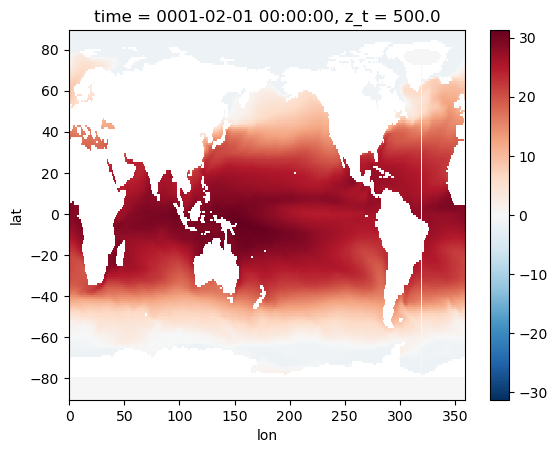

In [7]:
ds_tos.isel(time=0).plot()

## Subset data

In [8]:
#  Read Variable
area='Jakob'
if area == 'TROPIC':
    # central pacific coordinates
    arealat=(35,-35)
    arealon=[-180, 180.]
elif area == 'GLOBAL':
    arealat=(60,-60)
    arealon=[-160,110.]
elif area == 'WORLD':
    arealat=(60,-60)
    arealon=[-180,180.]
elif area == 'NAVARRA_2021':
    arealat=(-15,15)
    arealon=[140,290.]
elif area == 'Jakob':
    arealat=(-31,32)
    arealon=[130,290.]
else:
    Print(f'No area ')
    
case = 'UNIT'    
data_name= 'CESM'
variable='SST'
lev = 'SURF'
shift = 'ERA5'
period = 'ANN'
normalization = 'anom'

# Use SVD encoding
encode_svd = True
#Choose number of SVD to ratain
var_retained = None #None# Variance retained or None for full rank
#Option to write files
write_files = False

In [9]:
S_tos = ds_tos.sel(lat=slice(arealat[0],arealat[1]),lon=slice(arealon[0],arealon[1]))
S_ssh = ds_ssh.sel(lat=slice(arealat[0],arealat[1]),lon=slice(arealon[0],arealon[1]))

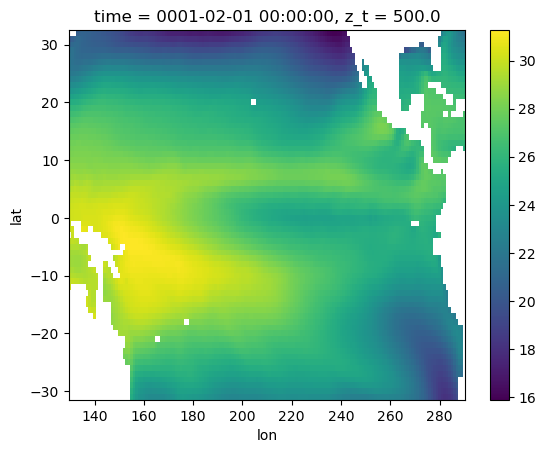

In [10]:
S_tos.isel(time=0).plot()

In [11]:
S_tos

<xarray.DataArray (time: 24000, lat: 64, lon: 161)>
[247296000 values with dtype=float32]
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    z_t      float32 ...
  * lon      (lon) int64 130 131 132 133 134 135 136 ... 285 286 287 288 289 290
  * lat      (lat) float64 -31.0 -30.0 -29.0 -28.0 -27.0 ... 29.0 30.0 31.0 32.0
Attributes:
    regrid_method:  bilinear

In [12]:
del(ds_tos, ds_ssh)

In [13]:
import psutil
psutil.virtual_memory() 

svmem(total=540408942592, available=518488313856, percent=4.1, used=18495012864, free=519591104512, active=802426880, inactive=10474012672, buffers=3805184, cached=2319020032, shared=211988480, slab=1469718528)

## Create matrices, de-trending data and anomalies

In [14]:
#Create Xmats
X_tos=zcom.Xmat(S_tos,dims=('lat','lon'))
X_tos.A = X_tos.A.dropna(dim='z')

 Created mathematical matrix A, 
                 stacked along dimensions ('lat', 'lon') 


In [15]:
X_ssh=zcom.Xmat(S_ssh,dims=('lat','lon'))
X_ssh.A = X_ssh.A.dropna(dim='z')

 Created mathematical matrix A, 
                 stacked along dimensions ('lat', 'lon') 


In [16]:
del(S_tos,S_ssh)

In [17]:
#Detrending
X_tos.detrend(axis=1)
X_ssh.detrend(axis=1)

Detrending data with options -->  {'axis': 1}
Detrending data with options -->  {'axis': 1}


In [18]:
#Anomalies
X_tos.anom(option='anomstd',freq='month')
X_ssh.anom(option='anomstd',freq='month')

# Identification of strong El Niño events

In [19]:
## Compute observations NON truncated to PCs
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]
Xindex

<xarray.DataArray (time: 24000)>
array([-0.07060368,  0.05651168,  0.28544566, ..., -0.90160394,
       -0.92717993, -0.8930959 ], dtype=float32)
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12 1

In [20]:
threshold_niño = np.percentile(Xindex, 99) # calculate the 10th percentile
threshold_niño

1.8835637521743764

In [21]:
extreme_niño= Xindex.data >= threshold_niño
print(np.where(extreme_niño)[0].shape)
np.where(extreme_niño)[0]

(240,)


array([    8,     9,    10,    11,    83,    84,    85,    86,   308,
         309,   930,   931,   932,   933,   934,   935,   936,  1915,
        1916,  1917,  1918,  1919,  1920,  2119,  2335,  2336,  2337,
        2338,  2418,  2419,  2420,  2421,  2422,  2467,  2468,  2469,
        3451,  3452,  3453,  3536,  4054,  4055,  4056,  5050,  5051,
        5972,  6120,  6121,  6236,  6237,  6238,  6239,  6414,  6415,
        6416,  6417,  6418,  6419,  6420,  6464,  6465,  6466,  6810,
        6811,  6812,  6813,  6814,  6815,  6816,  6817,  7090,  7414,
        7783,  7784,  7785,  7891,  7892,  7893,  8239,  8240,  8658,
        8768,  8769,  8771,  8772,  8878,  8879,  9514,  9607,  9608,
        9609,  9610,  9612,  9613,  9775,  9776,  9777,  9778,  9779,
       10225, 10315, 10316, 10317, 10318, 10319, 10448, 10557, 10558,
       10760, 10761, 10762, 10810, 10811, 11468, 11469, 11470, 11471,
       11472, 11473, 11696, 11698, 11701, 11702, 12009, 12010, 12011,
       12012, 12055,

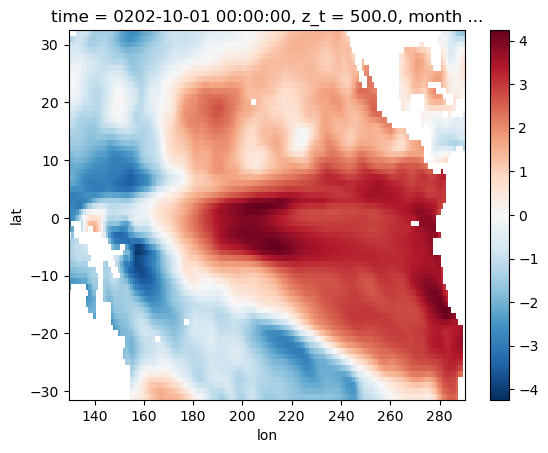

In [22]:
X_tos.A.unstack().isel(time=2420).plot()

# Identification of strong La niña events

In [23]:
## Compute observations NON truncated to PCs
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]
Xindex

<xarray.DataArray (time: 24000)>
array([-0.07060368,  0.05651168,  0.28544566, ..., -0.90160394,
       -0.92717993, -0.8930959 ], dtype=float32)
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12 1

In [24]:
print("Minimum value:", np.min(Xindex.data))
print("Maximum value:", np.max(Xindex.data))

Minimum value: -3.5291054
Maximum value: 2.874211


In [25]:
threshold_niña = np.percentile(Xindex, 1) # calculate the 10th percentile
threshold_niña

-2.2774467349052427

In [26]:
extreme_niña= Xindex.data <=threshold_niña
print(np.where(extreme_niña)[0].shape)
np.where(extreme_niña)[0]

(240,)


array([  318,  1113,  1222,  1223,  1226,  1227,  1228,  1229,  1688,
        1689,  1690,  1691,  1692,  1693,  1694,  1695,  1696,  1697,
        1698,  1928,  1929,  1930,  2439,  2440,  2441,  2442,  3548,
        3549,  3550,  3551,  3552,  3553,  3554,  3555,  3556,  3557,
        3558,  3559,  4617,  4838,  4839,  4840,  4841,  6249,  6255,
        6262,  6434,  6435,  6436,  6437,  6438,  6761,  7100,  7101,
        7102,  7103,  7104,  7107,  7108,  7250,  7251,  7252,  7253,
        8169,  8170,  8171,  8174,  8175,  8176,  8177,  8178, 10280,
       10281, 10283, 10284, 10285, 10286, 10288, 10289, 11187, 11188,
       11189, 11832, 11883, 11884, 11885, 11886, 12105, 12106, 12107,
       12108, 12109, 12110, 12111, 13010, 13011, 13013, 13862, 13863,
       13864, 13865, 13866, 14440, 14877, 14878, 14879, 14880, 14881,
       14882, 14883, 14884, 14885, 14886, 14887, 15218, 15219, 15220,
       15221, 16124, 16125, 16128, 16132, 16133, 16220, 16533, 16534,
       16535, 16702,

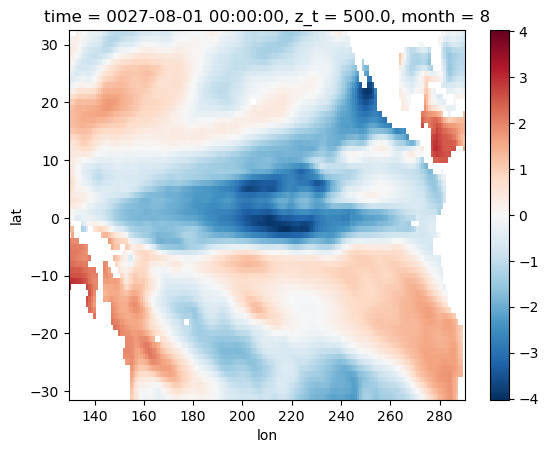

In [33]:
X_tos.A.unstack().isel(time=318).plot()

# Composite strong El Niño cases 5 months

In [39]:
cstr_GALL=np.zeros((np.where(extreme_niño)[0][4::].shape[0],24))
cstr_POLY= np.zeros((np.where(extreme_niño)[0][4::].shape[0],24))

In [40]:
## Load EOFs
PCs=np.load('Processed_data/PCs_CESM_845SST_1000SSH.npy')
EOFs=np.load('Processed_data/EOFs_CESM_845SST_1000SSH.npy')

In [41]:
periods=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
lead_times=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
leads=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]

### ALL GAUSS

In [31]:
#Select EOFs
udat_sst=EOFs[:,0:845]

In [32]:
## Compute observations NON truncated to PCs
Obs=X_tos.A.unstack()

In [ ]:
### Load data

tot_for=np.zeros((20, 17, 1845, 24, 1176))

for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 200/ALLEOFs_forecast_p{n}.npy')

tot_for_unionG=np.empty((17, 1845, 24, 24000))
tot_for_unionG.fill(np.NaN)

for m in lead_times:
    for n in periods:
        tot_for_unionG[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]

In [ ]:
tot_for_unionG=tot_for_unionG[(0,2,4,6,8,10,12,14,16),:,:,:]
tot_for_unionG.shape

### POLY

In [ ]:
#Select EOFs
udat_sst=EOFs[:,0:845]

In [ ]:
## Compute observations NON truncated to PCs
Obs=X_tos.A.unstack()

In [ ]:
### Load data

tot_for=np.zeros((20, 17, 30, 24, 1176))

for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 200/POLY_forecast_p{n}.npy')

tot_for_unionP=np.empty((17, 30, 24, 24000))
tot_for_unionP.fill(np.NaN)

for m in lead_times:
    for n in periods:
        tot_for_unionP[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]

In [ ]:
tot_for_unionP=tot_for_unionP[(0,2,4,6,8,10,12,14,16),:,:,:]
tot_for_unionP.shape

### CORRELATIONS

In [42]:
# Gaussian ALL
av_for_geo_ALL = xr.DataArray(
    data=None,
    dims=["z", "time", "init"],
    coords=dict(
        z=(X_tos.A.z),
        time=range(0,24),
        init=range(0,np.where(extreme_niño)[0][4::].shape[0]),
     ),
)

av_forALL=np.mean(tot_for_unionG, axis=0)

# Poly
av_for_geo_POLY = xr.DataArray(
    data=None,
    dims=["z", "time", "init"],
    coords=dict(
        z=(X_tos.A.z),
        time=range(0,24),
        init=range(0,np.where(extreme_niño)[0][4::].shape[0]),
     ),
)
av_forP=np.mean(tot_for_unionP, axis=0)

In [43]:
for j in range(np.where(extreme_niño)[0][4::].shape[0]):

    time_init=np.where(extreme_niño)[0][4::][j]-5
    X_tos.A[:, time_init]   # Inizia a JAN, max 20841 (NOV)
    
    # Gaussian ALL
    for n in range(24):
        lead=leads[n]
        av_for_geo_array=udat_sst @ av_forALL[0:845,lead,time_init+lead]            
        av_for_geo_ALL[:,n,j]=av_for_geo_array.real
    
    # Poly
    for n in range(24):
        lead=leads[n]
        av_for_geo_array=udat_sst[:,0:20] @ av_forP[0:20,lead,time_init+lead]            
        av_for_geo_POLY[:,n,j]=av_for_geo_array.real
    
    for i in range(24):
        corr=np.corrcoef(X_tos.A.isel(time=time_init+i),av_for_geo_ALL.isel(time=i).isel(init=j).astype(float))[0,1]
        cstr_GALL[j, i]=corr
    
    for i in range(24):
        corr=np.corrcoef(X_tos.A.isel(time=time_init+i),av_for_geo_POLY.isel(time=i).isel(init=j).astype(float))[0,1]
        cstr_POLY[j, i]=corr

In [44]:
np.nanmean(cstr_GALL, axis=0)

array([0.9742872 , 0.84110724, 0.82171155, 0.83009776, 0.84086489,
       0.84225919, 0.83534678, 0.82130373, 0.80132881, 0.77862065,
       0.74070532, 0.6890442 , 0.63710794, 0.58117659, 0.54990325,
       0.52345308, 0.49586652, 0.47406099, 0.47496477, 0.47717149,
       0.47111382, 0.47471387, 0.48600724, 0.49057492])

In [45]:
np.nanmean(cstr_POLY, axis=0)

array([0.89902062, 0.83307304, 0.78902654, 0.77517157, 0.77622332,
       0.77701862, 0.77104445, 0.75161437, 0.72045148, 0.67563584,
       0.61713187, 0.55356076, 0.49221831, 0.43153965, 0.38313205,
       0.3427256 , 0.30098264, 0.27144666, 0.26260409, 0.26317213,
       0.27166546, 0.29392236, 0.31594543, 0.32839129])

### Plot

In [46]:
average_sst_GALL=av_for_geo_ALL.mean(dim='init')
average_sst_GALL

<xarray.DataArray (z: 9121, time: 24)>
array([[-2.19732704e-01, -9.00477126e-02,  2.66265355e-04, ...,
         2.23753970e-01,  1.56287265e-01,  8.94543946e-02],
       [-2.01405893e-01, -6.50866577e-02,  1.45104756e-02, ...,
         2.74845371e-01,  2.07939402e-01,  1.41770041e-01],
       [-2.07630801e-01, -6.18251384e-02,  8.01757521e-03, ...,
         3.27687041e-01,  2.62413958e-01,  2.00559451e-01],
       ...,
       [ 7.68818491e-02, -1.74487147e-02,  3.21605472e-03, ...,
         1.38701364e-01,  1.29717328e-01,  1.52842947e-01],
       [ 7.94869055e-02, -1.34639985e-02,  9.06477973e-03, ...,
         1.13681566e-01,  1.08120377e-01,  1.35106380e-01],
       [ 8.36062358e-02, -1.06320485e-02,  1.40400188e-02, ...,
         9.44096426e-02,  9.18478748e-02,  1.18763153e-01]])
Coordinates:
  * z        (z) object MultiIndex
  * lat      (z) float64 -31.0 -31.0 -31.0 -31.0 -31.0 ... 32.0 32.0 32.0 32.0
  * lon      (z) int64 155 156 157 158 159 160 161 ... 285 286 287 288 289 290
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23

In [47]:
average_sst_POLY=av_for_geo_POLY.mean(dim='init')
average_sst_POLY

<xarray.DataArray (z: 9121, time: 24)>
array([[-0.3686625 , -0.28203253, -0.1991886 , ...,  0.21781909,
         0.18461155,  0.15030731],
       [-0.33821935, -0.25947373, -0.18185733, ...,  0.24909095,
         0.21400772,  0.17760603],
       [-0.33674764, -0.26497086, -0.19284828, ...,  0.2707021 ,
         0.23583955,  0.19923718],
       ...,
       [ 0.19950561,  0.10711872,  0.04088873, ...,  0.09217756,
         0.09646907,  0.09908944],
       [ 0.20223374,  0.11335109,  0.04873789, ...,  0.07587186,
         0.08127134,  0.08515885],
       [ 0.2039353 ,  0.11871215,  0.05616138, ...,  0.06353098,
         0.06952363,  0.07415879]])
Coordinates:
  * z        (z) object MultiIndex
  * lat      (z) float64 -31.0 -31.0 -31.0 -31.0 -31.0 ... 32.0 32.0 32.0 32.0
  * lon      (z) int64 155 156 157 158 159 160 161 ... 285 286 287 288 289 290
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23

 Opening figure , 7 rows and 3 cols 

Setting Fixed Contours
 Contouring from  -3.7   to 3.7  with interval   0.2
Setting Fixed Contours
 Contouring from  -3.7   to 3.7  with interval   0.2
Setting Fixed Contours
 Contouring from  -3.7   to 3.7  with interval   0.2
Setting Fixed Contours
 Contouring from  -3.7   to 3.7  with interval   0.2
Setting Fixed Contours
 Contouring from  -3.7   to 3.7  with interval   0.2
Setting Fixed Contours
 Contouring from  -3.7   to 3.7  with interval   0.2
Setting Fixed Contours
 Contouring from  -3.7   to 3.7  with interval   0.2
Setting Fixed Contours
 Contouring from  -2   to 2  with interval   0.2
Setting Fixed Contours
 Contouring from  -2   to 2  with interval   0.2
Setting Fixed Contours
 Contouring from  -2   to 2  with interval   0.2
Setting Fixed Contours
 Contouring from  -2   to 2  with interval   0.2
Setting Fixed Contours
 Contouring from  -2   to 2  with interval   0.2
Setting Fixed Contours
 Contouring from  -2   to 2  with interval   0.

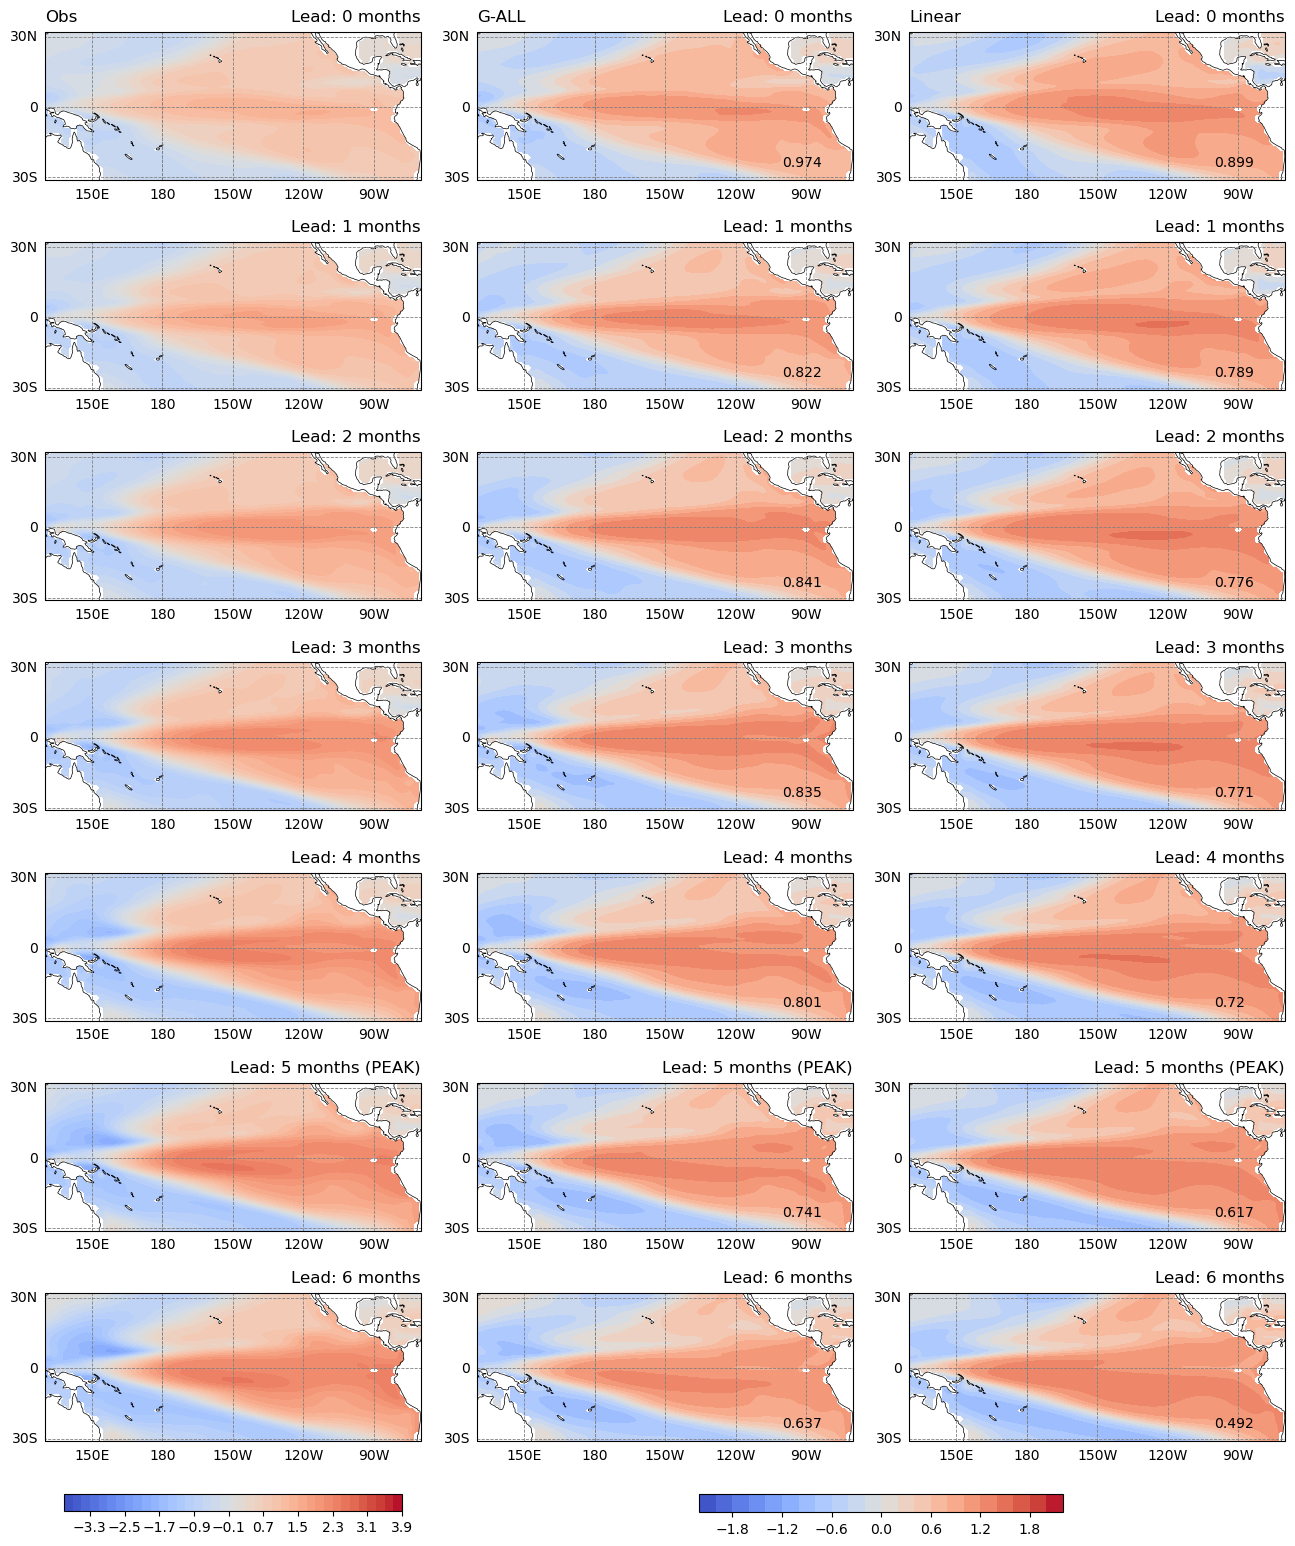

In [49]:
columns = 3
rows = 7
cont=[-3.7,3.7,0.2]
cont1=[-2,2,0.2]

fig,ax,pro=zmap.init_figure(rows,columns,'Pacific', constrained_layout=False, figsize=(16,23), sharex=True, sharey=True )

axh=ax[0,0]


#Observations
handle=zmap.xmap(X_tos.A.unstack().isel(time=np.where(extreme_niño)[0][4::]-5).mean(dim='time'),cont, pro, ax=ax[0,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 0 months', 'lefttitle':'Obs','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(X_tos.A.unstack().isel(time=np.where(extreme_niño)[0][4::]-4).mean(dim='time'),cont, pro, ax=ax[1,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 1 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(X_tos.A.unstack().isel(time=np.where(extreme_niño)[0][4::]-3).mean(dim='time'),cont, pro, ax=ax[2,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 2 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(X_tos.A.unstack().isel(time=np.where(extreme_niño)[0][4::]-2).mean(dim='time'),cont, pro, ax=ax[3,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 3 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(X_tos.A.unstack().isel(time=np.where(extreme_niño)[0][4::]-1).mean(dim='time'),cont, pro, ax=ax[4,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 4 months' , 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(X_tos.A.unstack().isel(time=np.where(extreme_niño)[0][4::]).mean(dim='time'),cont, pro, ax=ax[5,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 5 months (PEAK)', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(X_tos.A.unstack().isel(time=np.where(extreme_niño)[0][4::]+1).mean(dim='time'),cont, pro, ax=ax[6,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 6 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))


# G-ALL
handle1=zmap.xmap(average_sst_GALL.unstack().isel(time=0),cont1, pro, ax=ax[0,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 0 months', 'lefttitle':'G-ALL','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_GALL.unstack().isel(time=1),cont1, pro, ax=ax[1,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 1 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_GALL.unstack().isel(time=2),cont1, pro, ax=ax[2,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 2 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_GALL.unstack().isel(time=3),cont1, pro, ax=ax[3,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 3 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_GALL.unstack().isel(time=4),cont1, pro, ax=ax[4,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 4 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_GALL.unstack().isel(time=5),cont1, pro, ax=ax[5,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 5 months (PEAK)', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_GALL.unstack().isel(time=6),cont1, pro, ax=ax[6,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 6 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))


# POLY
handle1=zmap.xmap(average_sst_POLY.unstack().isel(time=0),cont1, pro, ax=ax[0,2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 0 months', 'lefttitle':'Linear','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_POLY.unstack().isel(time=1),cont1, pro, ax=ax[1,2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 1 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_POLY.unstack().isel(time=2),cont1, pro, ax=ax[2,2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 2 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_POLY.unstack().isel(time=3),cont1, pro, ax=ax[3,2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 3 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_POLY.unstack().isel(time=4),cont1, pro, ax=ax[4,2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 4 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_POLY.unstack().isel(time=5),cont1, pro, ax=ax[5,2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 5 months (PEAK)', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_POLY.unstack().isel(time=6),cont1, pro, ax=ax[6,2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 6 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))


ax[0,1].text(80,-25,np.around(np.nanmean(cstr_GALL, axis=0)[0], decimals=3))
ax[1,1].text(80,-25,np.around(np.nanmean(cstr_GALL, axis=0)[2], decimals=3))
ax[2,1].text(80,-25,np.around(np.nanmean(cstr_GALL, axis=0)[4], decimals=3))
ax[3,1].text(80,-25,np.around(np.nanmean(cstr_GALL, axis=0)[6], decimals=3))
ax[4,1].text(80,-25,np.around(np.nanmean(cstr_GALL, axis=0)[8], decimals=3))
ax[5,1].text(80,-25,np.around(np.nanmean(cstr_GALL, axis=0)[10], decimals=3))
ax[6,1].text(80,-25,np.around(np.nanmean(cstr_GALL, axis=0)[12], decimals=3))
ax[0,2].text(80,-25,np.around(np.nanmean(cstr_POLY, axis=0)[0], decimals=3))
ax[1,2].text(80,-25,np.around(np.nanmean(cstr_POLY, axis=0)[2], decimals=3))
ax[2,2].text(80,-25,np.around(np.nanmean(cstr_POLY, axis=0)[4], decimals=3))
ax[3,2].text(80,-25,np.around(np.nanmean(cstr_POLY, axis=0)[6], decimals=3))
ax[4,2].text(80,-25,np.around(np.nanmean(cstr_POLY, axis=0)[8], decimals=3))
ax[5,2].text(80,-25,np.around(np.nanmean(cstr_POLY, axis=0)[10], decimals=3))
ax[6,2].text(80,-25,np.around(np.nanmean(cstr_POLY, axis=0)[12], decimals=3))

axh.xaxis.set_tick_params(labelbottom=True)
zmap.changelabel(axh,fontsize=14,fontfamily='Futura',fontweight='bold')
zmap.changebox(axh,'all',linewidth=1.5)  
        
plt.subplots_adjust(wspace=0.15,hspace=0.1)
fig.colorbar(handle['filled'], ax=ax[:, 0],shrink=0.9, orientation = 'horizontal',pad=0.03)
fig.colorbar(handle1['filled'], ax=ax[:, 1:3],shrink=0.45, orientation = 'horizontal',pad=0.03)
#plt.savefig('Fig 12.pdf', orientation='landscape',  format='pdf')
#plt.savefig('Fig 12.jpg', orientation='landscape',  format='jpg')


plt.show()

# Composite strong El Niño cases 10 months

In [28]:
cstr_GALL=np.zeros((np.where(extreme_niño)[0][4::].shape[0],24))
cstr_POLY= np.zeros((np.where(extreme_niño)[0][4::].shape[0],24))

In [29]:
## Load EOFs
PCs=np.load('Processed_data/PCs_CESM_845SST_1000SSH.npy')
EOFs=np.load('Processed_data/EOFs_CESM_845SST_1000SSH.npy')

In [30]:
periods=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
lead_times=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
leads=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]

### ALL GAUSS

In [31]:
#Select EOFs
udat_sst=EOFs[:,0:845]

In [32]:
## Compute observations NON truncated to PCs
Obs=X_tos.A.unstack()

In [33]:
### Load data

tot_for=np.zeros((20, 17, 1845, 24, 1176))

for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 200/ALLEOFs_forecast_p{n}.npy')

tot_for_unionG=np.empty((17, 1845, 24, 24000))
tot_for_unionG.fill(np.NaN)

for m in lead_times:
    for n in periods:
        tot_for_unionG[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]

In [34]:
tot_for_unionG=tot_for_unionG[(0,2,4,6,8,10,12,14,16),:,:,:]
tot_for_unionG.shape

(9, 1845, 24, 24000)

### POLY

In [35]:
#Select EOFs
udat_sst=EOFs[:,0:845]

In [36]:
## Compute observations NON truncated to PCs
Obs=X_tos.A.unstack()

In [37]:
### Load data

tot_for=np.zeros((20, 17, 30, 24, 1176))

for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 200/POLY_forecast_p{n}.npy')

tot_for_unionP=np.empty((17, 30, 24, 24000))
tot_for_unionP.fill(np.NaN)

for m in lead_times:
    for n in periods:
        tot_for_unionP[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]

In [38]:
tot_for_unionP=tot_for_unionP[(0,2,4,6,8,10,12,14,16),:,:,:]
tot_for_unionP.shape

(9, 30, 24, 24000)

### CORRELATIONS

In [136]:
# Gaussian ALL
av_for_geo_ALL = xr.DataArray(
    data=None,
    dims=["z", "time", "init"],
    coords=dict(
        z=(X_tos.A.z),
        time=range(0,24),
        init=range(0,np.where(extreme_niño)[0][4::].shape[0]),
     ),
)

av_forALL=np.mean(tot_for_unionG, axis=0)

# Poly
av_for_geo_POLY = xr.DataArray(
    data=None,
    dims=["z", "time", "init"],
    coords=dict(
        z=(X_tos.A.z),
        time=range(0,24),
        init=range(0,np.where(extreme_niño)[0][4::].shape[0]),
     ),
)
av_forP=np.mean(tot_for_unionP, axis=0)

In [137]:
for j in range(np.where(extreme_niño)[0][4::].shape[0]):

    time_init=np.where(extreme_niño)[0][4::][j]-10
    X_tos.A[:, time_init]   # Inizia a JAN, max 20841 (NOV)
    
    # Gaussian ALL
    for n in range(24):
        lead=leads[n]
        av_for_geo_array=udat_sst @ av_forALL[0:845,lead,time_init+lead]            
        av_for_geo_ALL[:,n,j]=av_for_geo_array.real
    
    # Poly
    for n in range(24):
        lead=leads[n]
        av_for_geo_array=udat_sst[:,0:20] @ av_forP[0:20,lead,time_init+lead]            
        av_for_geo_POLY[:,n,j]=av_for_geo_array.real
    
    for i in range(24):
        corr=np.corrcoef(X_tos.A.isel(time=time_init+i),av_for_geo_ALL.isel(time=i).isel(init=j).astype(float))[0,1]
        cstr_GALL[j, i]=corr
    
    for i in range(24):
        corr=np.corrcoef(X_tos.A.isel(time=time_init+i),av_for_geo_POLY.isel(time=i).isel(init=j).astype(float))[0,1]
        cstr_POLY[j, i]=corr

In [138]:
np.nanmean(cstr_GALL, axis=0)

array([0.974432  , 0.72279303, 0.60900902, 0.57656037, 0.56822555,
       0.579859  , 0.61485504, 0.63473992, 0.66375935, 0.68064774,
       0.6765504 , 0.66139251, 0.64178019, 0.60882937, 0.57967871,
       0.53193951, 0.47787055, 0.41684311, 0.37784957, 0.3550938 ,
       0.33233125, 0.31129505, 0.29522251, 0.29265419])

In [139]:
np.nanmean(cstr_POLY, axis=0)

array([0.86592464, 0.71603631, 0.59279853, 0.53405243, 0.5178462 ,
       0.51815814, 0.53484946, 0.54320447, 0.550557  , 0.55206103,
       0.54333229, 0.52315784, 0.49281089, 0.45361298, 0.40708879,
       0.35942838, 0.31553238, 0.27666108, 0.2375527 , 0.21480113,
       0.20699537, 0.19694157, 0.19865603, 0.20340899])

### Plot

In [140]:
average_sst_GALL=av_for_geo_ALL.mean(dim='init')
average_sst_GALL

<xarray.DataArray (z: 9121, time: 24)>
array([[-0.17055286, -0.14120056, -0.12723431, ...,  0.24460697,
         0.21443166,  0.17152474],
       [-0.18648469, -0.14452834, -0.11932307, ...,  0.2702704 ,
         0.24374782,  0.20129277],
       [-0.20990279, -0.16132393, -0.12661271, ...,  0.28704142,
         0.26516406,  0.22508396],
       ...,
       [ 0.09444251,  0.02482123,  0.01298584, ...,  0.05614405,
         0.04420721,  0.02322523],
       [ 0.10343836,  0.02501803,  0.01527172, ...,  0.03764169,
         0.02719703,  0.00879939],
       [ 0.11166632,  0.02709663,  0.01770941, ...,  0.02316475,
         0.01454454, -0.00294902]])
Coordinates:
  * z        (z) object MultiIndex
  * lat      (z) float64 -31.0 -31.0 -31.0 -31.0 -31.0 ... 32.0 32.0 32.0 32.0
  * lon      (z) int64 155 156 157 158 159 160 161 ... 285 286 287 288 289 290
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23

In [141]:
average_sst_POLY=av_for_geo_POLY.mean(dim='init')
average_sst_POLY

<xarray.DataArray (z: 9121, time: 24)>
array([[-0.10540399, -0.13207354, -0.14141725, ...,  0.1242088 ,
         0.11358739,  0.10128844],
       [-0.11264638, -0.13400201, -0.13995875, ...,  0.14105897,
         0.12998251,  0.11705444],
       [-0.13129621, -0.14878276, -0.15232158, ...,  0.14977616,
         0.13936819,  0.12688669],
       ...,
       [ 0.17341611,  0.13939943,  0.10338618, ...,  0.02162023,
         0.02591108,  0.02953178],
       [ 0.17017592,  0.13665749,  0.10129188, ...,  0.01281351,
         0.0173748 ,  0.02137969],
       [ 0.16714754,  0.13434522,  0.09983451, ...,  0.00678757,
         0.01139992,  0.01555194]])
Coordinates:
  * z        (z) object MultiIndex
  * lat      (z) float64 -31.0 -31.0 -31.0 -31.0 -31.0 ... 32.0 32.0 32.0 32.0
  * lon      (z) int64 155 156 157 158 159 160 161 ... 285 286 287 288 289 290
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23

 Opening figure , 7 rows and 3 cols 

Setting Fixed Contours
 Contouring from  -3.7   to 3.7  with interval   0.2
Setting Fixed Contours
 Contouring from  -3.7   to 3.7  with interval   0.2
Setting Fixed Contours
 Contouring from  -3.7   to 3.7  with interval   0.2
Setting Fixed Contours
 Contouring from  -3.7   to 3.7  with interval   0.2
Setting Fixed Contours
 Contouring from  -3.7   to 3.7  with interval   0.2
Setting Fixed Contours
 Contouring from  -3.7   to 3.7  with interval   0.2
Setting Fixed Contours
 Contouring from  -3.7   to 3.7  with interval   0.2
Setting Fixed Contours
 Contouring from  -1.7   to 1.7  with interval   0.1
Setting Fixed Contours
 Contouring from  -1.7   to 1.7  with interval   0.1
Setting Fixed Contours
 Contouring from  -1.7   to 1.7  with interval   0.1
Setting Fixed Contours
 Contouring from  -1.7   to 1.7  with interval   0.1
Setting Fixed Contours
 Contouring from  -1.7   to 1.7  with interval   0.1
Setting Fixed Contours
 Contouring from  -1.7   to

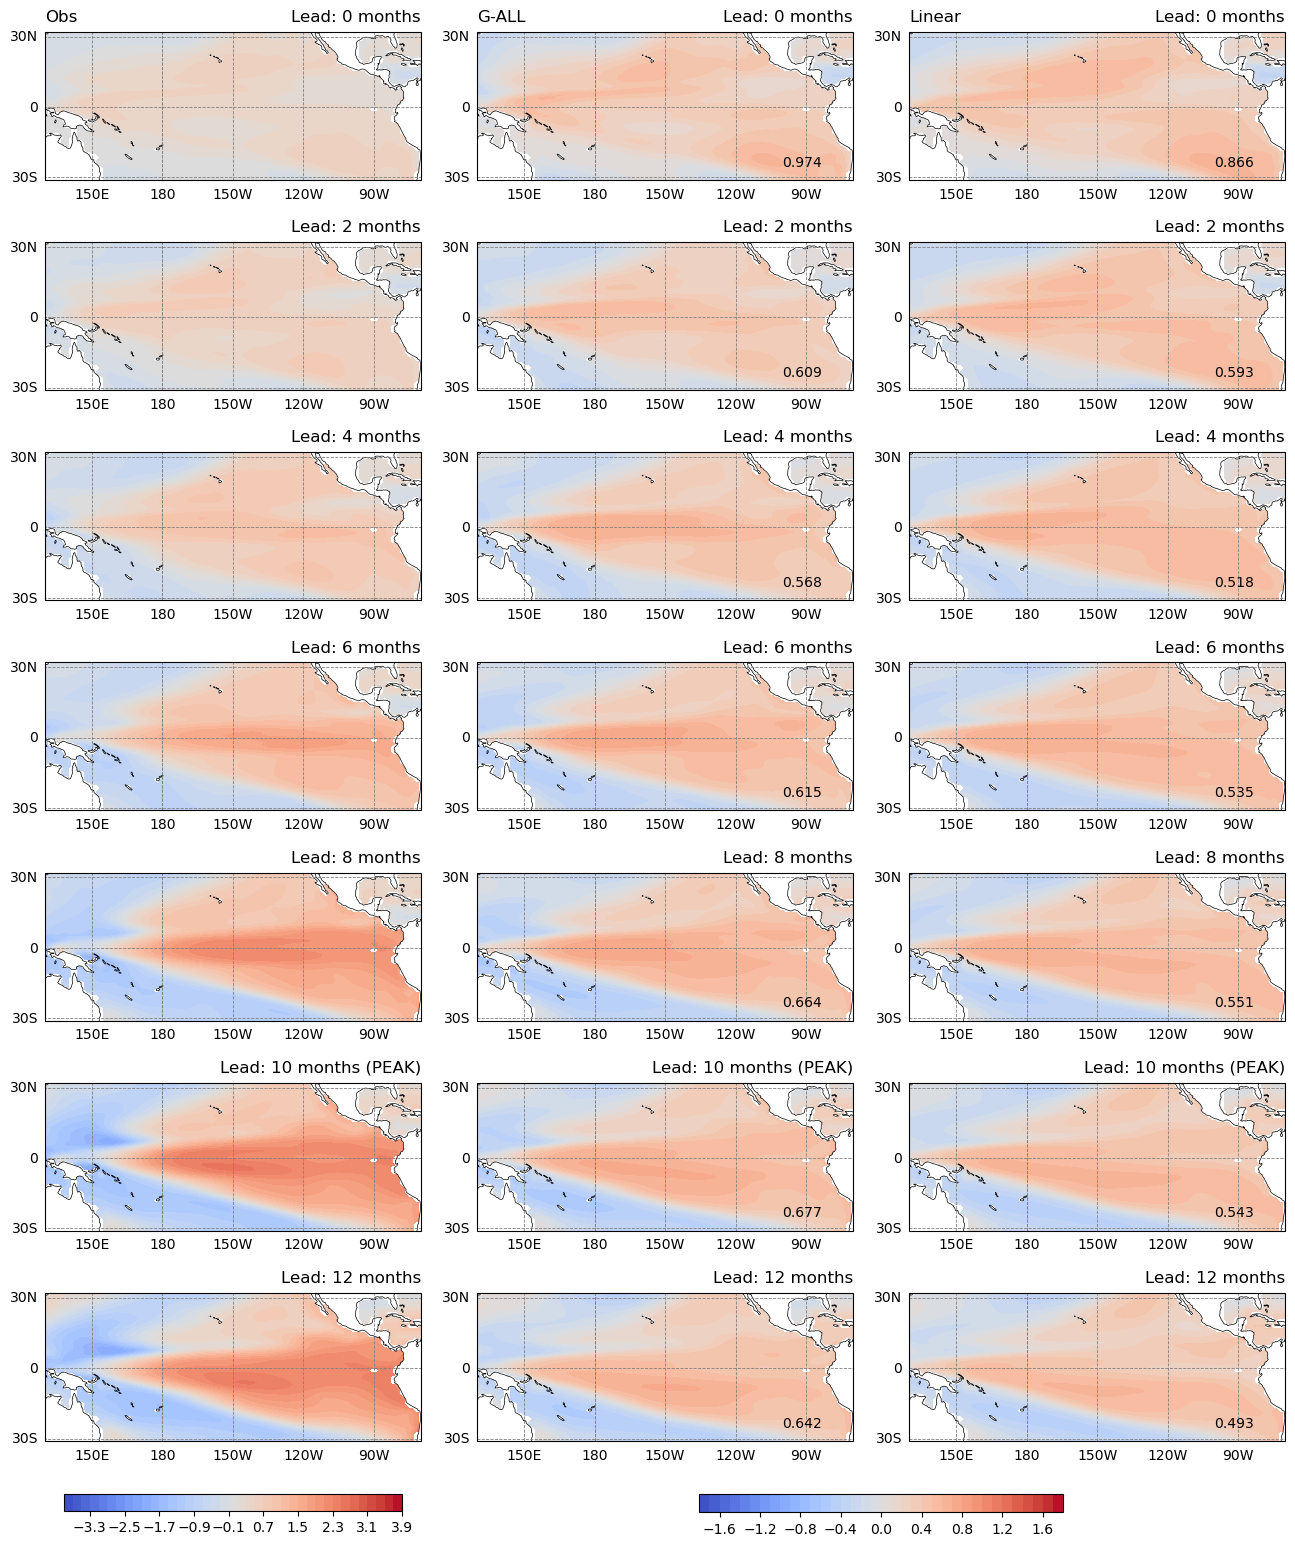

In [144]:
columns = 3
rows = 7
cont=[-3.7,3.7,0.2]
cont1=[-1.7,1.7,0.1]

fig,ax,pro=zmap.init_figure(rows,columns,'Pacific', constrained_layout=False, figsize=(16,23), sharex=True, sharey=True )

axh=ax[0,0]


#Observations
handle=zmap.xmap(X_tos.A.unstack().isel(time=np.where(extreme_niño)[0][4::]-10).mean(dim='time'),cont, pro, ax=ax[0,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 0 months', 'lefttitle':'Obs','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(X_tos.A.unstack().isel(time=np.where(extreme_niño)[0][4::]+1*2-10).mean(dim='time'),cont, pro, ax=ax[1,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 2 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(X_tos.A.unstack().isel(time=np.where(extreme_niño)[0][4::]+2*2-10).mean(dim='time'),cont, pro, ax=ax[2,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 4 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(X_tos.A.unstack().isel(time=np.where(extreme_niño)[0][4::]+3*2-10).mean(dim='time'),cont, pro, ax=ax[3,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 6 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(X_tos.A.unstack().isel(time=np.where(extreme_niño)[0][4::]+4*2-10).mean(dim='time'),cont, pro, ax=ax[4,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 8 months' , 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(X_tos.A.unstack().isel(time=np.where(extreme_niño)[0][4::]+5*2-10).mean(dim='time'),cont, pro, ax=ax[5,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 10 months (PEAK)', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(X_tos.A.unstack().isel(time=np.where(extreme_niño)[0][4::]+6*2-10).mean(dim='time'),cont, pro, ax=ax[6,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 12 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))


# G-ALL
handle1=zmap.xmap(average_sst_GALL.unstack().isel(time=0),cont1, pro, ax=ax[0,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 0 months', 'lefttitle':'G-ALL','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_GALL.unstack().isel(time=2),cont1, pro, ax=ax[1,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 2 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_GALL.unstack().isel(time=4),cont1, pro, ax=ax[2,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 4 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_GALL.unstack().isel(time=6),cont1, pro, ax=ax[3,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 6 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_GALL.unstack().isel(time=8),cont1, pro, ax=ax[4,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 8 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_GALL.unstack().isel(time=10),cont1, pro, ax=ax[5,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 10 months (PEAK)', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_GALL.unstack().isel(time=12),cont1, pro, ax=ax[6,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 12 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))


# POLY
handle1=zmap.xmap(average_sst_POLY.unstack().isel(time=0),cont1, pro, ax=ax[0,2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 0 months', 'lefttitle':'Linear','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_POLY.unstack().isel(time=2),cont1, pro, ax=ax[1,2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 2 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_POLY.unstack().isel(time=4),cont1, pro, ax=ax[2,2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 4 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_POLY.unstack().isel(time=6),cont1, pro, ax=ax[3,2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 6 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_POLY.unstack().isel(time=8),cont1, pro, ax=ax[4,2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 8 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_POLY.unstack().isel(time=10),cont1, pro, ax=ax[5,2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 10 months (PEAK)', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_POLY.unstack().isel(time=12),cont1, pro, ax=ax[6,2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 12 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))


ax[0,1].text(80,-25,np.around(np.nanmean(cstr_GALL, axis=0)[0], decimals=3))
ax[1,1].text(80,-25,np.around(np.nanmean(cstr_GALL, axis=0)[2], decimals=3))
ax[2,1].text(80,-25,np.around(np.nanmean(cstr_GALL, axis=0)[4], decimals=3))
ax[3,1].text(80,-25,np.around(np.nanmean(cstr_GALL, axis=0)[6], decimals=3))
ax[4,1].text(80,-25,np.around(np.nanmean(cstr_GALL, axis=0)[8], decimals=3))
ax[5,1].text(80,-25,np.around(np.nanmean(cstr_GALL, axis=0)[10], decimals=3))
ax[6,1].text(80,-25,np.around(np.nanmean(cstr_GALL, axis=0)[12], decimals=3))
ax[0,2].text(80,-25,np.around(np.nanmean(cstr_POLY, axis=0)[0], decimals=3))
ax[1,2].text(80,-25,np.around(np.nanmean(cstr_POLY, axis=0)[2], decimals=3))
ax[2,2].text(80,-25,np.around(np.nanmean(cstr_POLY, axis=0)[4], decimals=3))
ax[3,2].text(80,-25,np.around(np.nanmean(cstr_POLY, axis=0)[6], decimals=3))
ax[4,2].text(80,-25,np.around(np.nanmean(cstr_POLY, axis=0)[8], decimals=3))
ax[5,2].text(80,-25,np.around(np.nanmean(cstr_POLY, axis=0)[10], decimals=3))
ax[6,2].text(80,-25,np.around(np.nanmean(cstr_POLY, axis=0)[12], decimals=3))

axh.xaxis.set_tick_params(labelbottom=True)
zmap.changelabel(axh,fontsize=14,fontfamily='Futura',fontweight='bold')
zmap.changebox(axh,'all',linewidth=1.5)  
        
plt.subplots_adjust(wspace=0.15,hspace=0.1)
fig.colorbar(handle['filled'], ax=ax[:, 0],shrink=0.9, orientation = 'horizontal',pad=0.03)
fig.colorbar(handle1['filled'], ax=ax[:, 1:3],shrink=0.45, orientation = 'horizontal',pad=0.03)
#plt.savefig('Fig 12.pdf', orientation='landscape',  format='pdf')
#plt.savefig('Fig 12.jpg', orientation='landscape',  format='jpg')


plt.show()

# Composite strong El Niño cases 15 months

In [34]:
cstr_GALL=np.zeros((np.where(extreme_niño)[0][4::].shape[0],24))
cstr_POLY= np.zeros((np.where(extreme_niño)[0][4::].shape[0],24))

In [35]:
## Load EOFs
PCs=np.load('Processed_data/PCs_CESM_845SST_1000SSH.npy')
EOFs=np.load('Processed_data/EOFs_CESM_845SST_1000SSH.npy')

In [36]:
periods=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
lead_times=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
leads=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]

### ALL GAUSS

In [37]:
#Select EOFs
udat_sst=EOFs[:,0:845]

In [38]:
## Compute observations NON truncated to PCs
Obs=X_tos.A.unstack()

In [ ]:
### Load data

tot_for=np.zeros((20, 17, 1845, 24, 1176))

for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 200/ALLEOFs_forecast_p{n}.npy')

tot_for_unionG=np.empty((17, 1845, 24, 24000))
tot_for_unionG.fill(np.NaN)

for m in lead_times:
    for n in periods:
        tot_for_unionG[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]

In [ ]:
tot_for_unionG=tot_for_unionG[(0,2,4,6,8,10,12,14,16),:,:,:]
tot_for_unionG.shape

### POLY

In [ ]:
#Select EOFs
udat_sst=EOFs[:,0:845]

In [ ]:
## Compute observations NON truncated to PCs
Obs=X_tos.A.unstack()

In [ ]:
### Load data

tot_for=np.zeros((20, 17, 30, 24, 1176))

for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 200/POLY_forecast_p{n}.npy')

tot_for_unionP=np.empty((17, 30, 24, 24000))
tot_for_unionP.fill(np.NaN)

for m in lead_times:
    for n in periods:
        tot_for_unionP[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]

In [ ]:
tot_for_unionP=tot_for_unionP[(0,2,4,6,8,10,12,14,16),:,:,:]
tot_for_unionP.shape

### CORRELATIONS

In [40]:
# Gaussian ALL
av_for_geo_ALL = xr.DataArray(
    data=None,
    dims=["z", "time", "init"],
    coords=dict(
        z=(X_tos.A.z),
        time=range(0,24),
        init=range(0,np.where(extreme_niño)[0][4::].shape[0]),
     ),
)

av_forALL=np.mean(tot_for_unionG, axis=0)

# Poly
av_for_geo_POLY = xr.DataArray(
    data=None,
    dims=["z", "time", "init"],
    coords=dict(
        z=(X_tos.A.z),
        time=range(0,24),
        init=range(0,np.where(extreme_niño)[0][4::].shape[0]),
     ),
)
av_forP=np.mean(tot_for_unionP, axis=0)

In [41]:
for j in range(np.where(extreme_niño)[0][4::].shape[0]):

    time_init=np.where(extreme_niño)[0][4::][j]-15
    X_tos.A[:, time_init]   # Inizia a JAN, max 20841 (NOV)
    
    # Gaussian ALL
    for n in range(24):
        lead=leads[n]
        av_for_geo_array=udat_sst @ av_forALL[0:845,lead,time_init+lead]            
        av_for_geo_ALL[:,n,j]=av_for_geo_array.real
    
    # Poly
    for n in range(24):
        lead=leads[n]
        av_for_geo_array=udat_sst[:,0:20] @ av_forP[0:20,lead,time_init+lead]            
        av_for_geo_POLY[:,n,j]=av_for_geo_array.real
    
    for i in range(24):
        corr=np.corrcoef(X_tos.A.isel(time=time_init+i),av_for_geo_ALL.isel(time=i).isel(init=j).astype(float))[0,1]
        cstr_GALL[j, i]=corr
    
    for i in range(24):
        corr=np.corrcoef(X_tos.A.isel(time=time_init+i),av_for_geo_POLY.isel(time=i).isel(init=j).astype(float))[0,1]
        cstr_POLY[j, i]=corr

In [42]:
np.nanmean(cstr_GALL, axis=0)

array([0.97683889, 0.7592454 , 0.64833747, 0.57360952, 0.5106182 ,
       0.45661343, 0.42314581, 0.40583826, 0.40689698, 0.41900409,
       0.4422462 , 0.46127372, 0.48171664, 0.49304909, 0.49346352,
       0.49318989, 0.46788618, 0.43491662, 0.41932807, 0.38842302,
       0.34861077, 0.30909966, 0.27437731, 0.24268813])

In [43]:
np.nanmean(cstr_POLY, axis=0)

array([0.87975836, 0.77053592, 0.66170892, 0.57374036, 0.50179604,
       0.43938423, 0.39410781, 0.3707891 , 0.36572414, 0.36994771,
       0.38670515, 0.40118083, 0.41298209, 0.42145   , 0.42259836,
       0.41690831, 0.39635018, 0.36817569, 0.3308117 , 0.28358755,
       0.23919603, 0.2017932 , 0.17400691, 0.14995571])

### Plot

In [44]:
average_sst_GALL=av_for_geo_ALL.mean(dim='init')
average_sst_GALL

<xarray.DataArray (z: 9121, time: 24)>
array([[-0.14293846, -0.16863628, -0.17129572, ...,  0.13847852,
         0.15478377,  0.15913591],
       [-0.14166283, -0.17272106, -0.16562581, ...,  0.13693833,
         0.15866791,  0.16109159],
       [-0.13888003, -0.18062031, -0.16627697, ...,  0.12400679,
         0.15125732,  0.15338935],
       ...,
       [-0.16807044, -0.06757881, -0.05036127, ...,  0.00968763,
         0.00635474,  0.01661386],
       [-0.15865526, -0.06071727, -0.04643634, ...,  0.0067029 ,
         0.00049965,  0.01118537],
       [-0.15065396, -0.05472159, -0.04328294, ...,  0.0035369 ,
        -0.00518144,  0.00632784]])
Coordinates:
  * z        (z) object MultiIndex
  * lat      (z) float64 -31.0 -31.0 -31.0 -31.0 -31.0 ... 32.0 32.0 32.0 32.0
  * lon      (z) int64 155 156 157 158 159 160 161 ... 285 286 287 288 289 290
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23

In [45]:
average_sst_POLY=av_for_geo_POLY.mean(dim='init')
average_sst_POLY

<xarray.DataArray (z: 9121, time: 24)>
array([[-0.03378633, -0.0691829 , -0.08991258, ...,  0.08469803,
         0.08445356,  0.0822208 ],
       [-0.03915784, -0.07377153, -0.09370298, ...,  0.09394249,
         0.09386307,  0.09164424],
       [-0.04863386, -0.08235318, -0.10166156, ...,  0.09672228,
         0.09749453,  0.09599804],
       ...,
       [-0.03655297,  0.00544097,  0.02975879, ..., -0.00361602,
         0.00076182,  0.00482076],
       [-0.02792129,  0.01164101,  0.03417995, ..., -0.00841637,
        -0.00420233, -0.00020551],
       [-0.02187325,  0.01572965,  0.03691406, ..., -0.01134514,
        -0.00736082, -0.00351745]])
Coordinates:
  * z        (z) object MultiIndex
  * lat      (z) float64 -31.0 -31.0 -31.0 -31.0 -31.0 ... 32.0 32.0 32.0 32.0
  * lon      (z) int64 155 156 157 158 159 160 161 ... 285 286 287 288 289 290
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23

 Opening figure , 7 rows and 3 cols 

Setting Fixed Contours
 Contouring from  -3.7   to 3.7  with interval   0.2
Setting Fixed Contours
 Contouring from  -3.7   to 3.7  with interval   0.2
Setting Fixed Contours
 Contouring from  -3.7   to 3.7  with interval   0.2
Setting Fixed Contours
 Contouring from  -3.7   to 3.7  with interval   0.2
Setting Fixed Contours
 Contouring from  -3.7   to 3.7  with interval   0.2
Setting Fixed Contours
 Contouring from  -3.7   to 3.7  with interval   0.2
Setting Fixed Contours
 Contouring from  -3.7   to 3.7  with interval   0.2
Setting Fixed Contours
 Contouring from  -0.7   to 0.7  with interval   0.1
Setting Fixed Contours
 Contouring from  -0.7   to 0.7  with interval   0.1
Setting Fixed Contours
 Contouring from  -0.7   to 0.7  with interval   0.1
Setting Fixed Contours
 Contouring from  -0.7   to 0.7  with interval   0.1
Setting Fixed Contours
 Contouring from  -0.7   to 0.7  with interval   0.1
Setting Fixed Contours
 Contouring from  -0.7   to

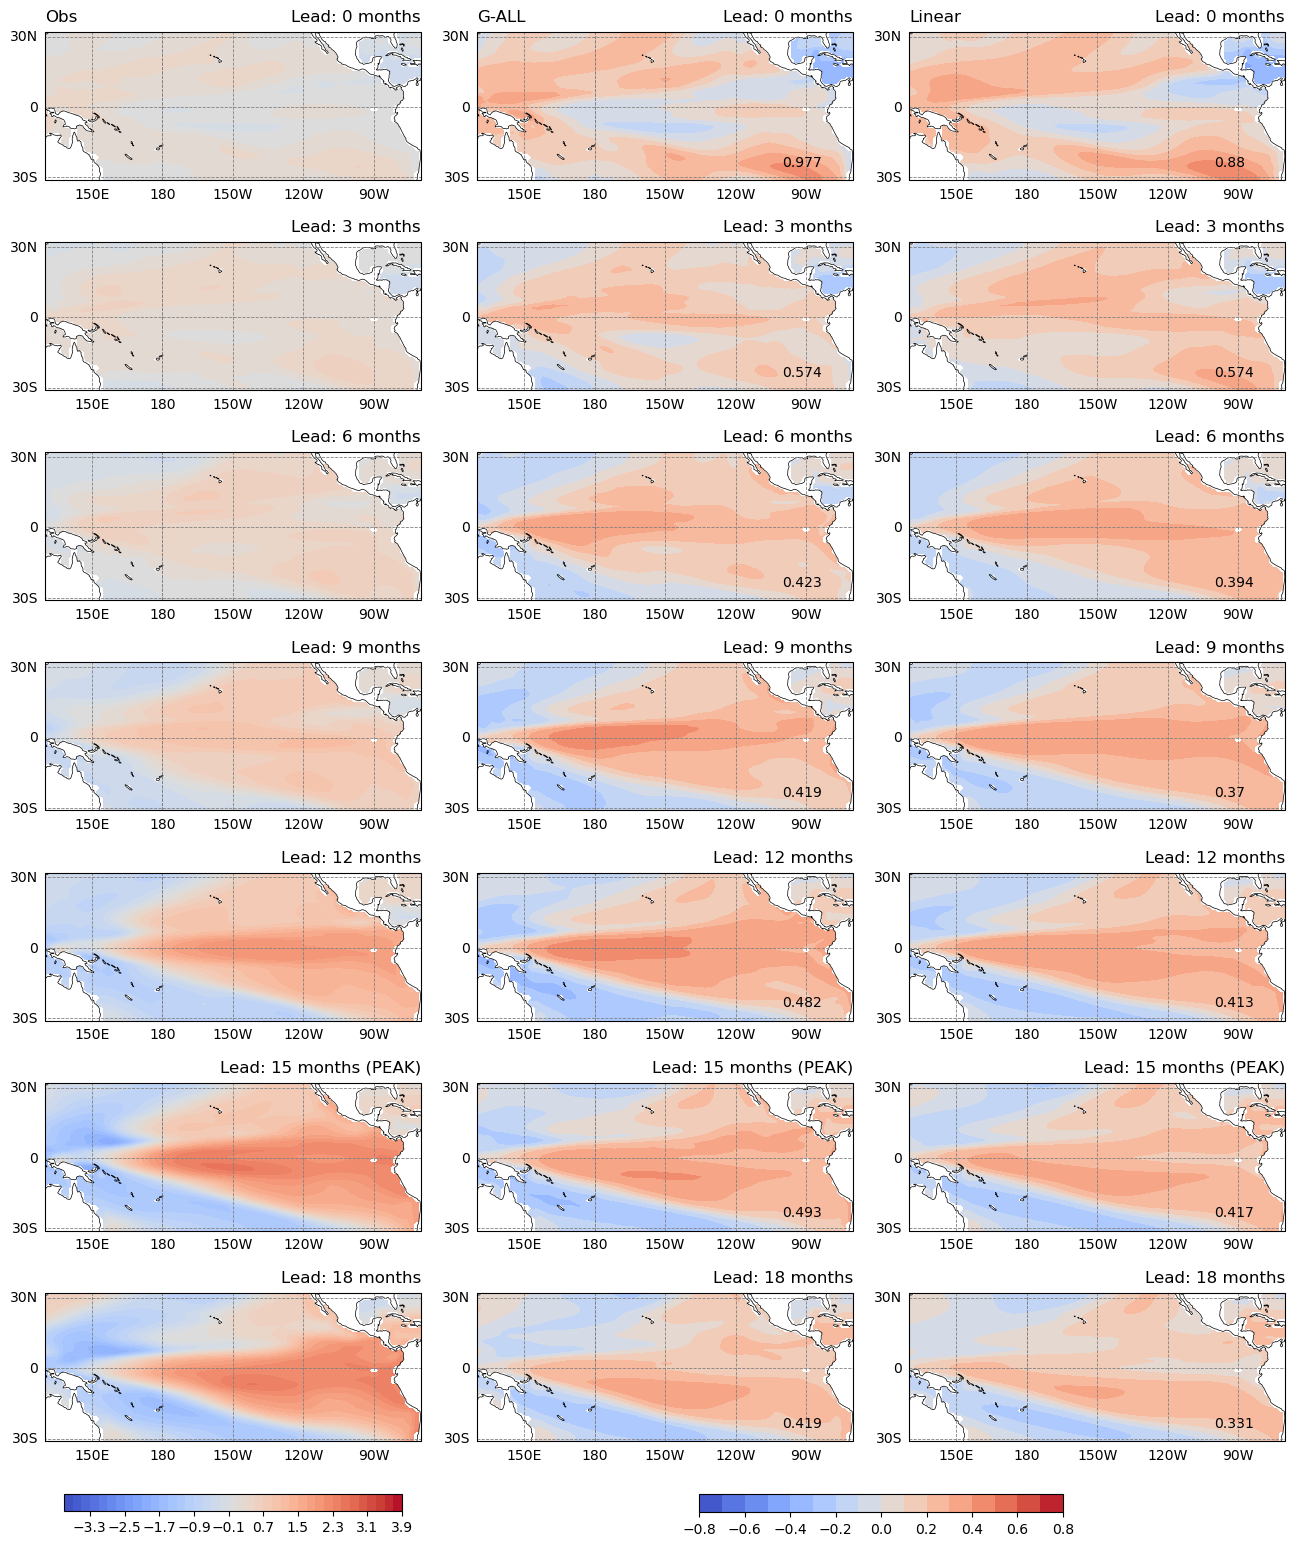

In [46]:
columns = 3
rows = 7
cont=[-3.7,3.7,0.2]
cont1=[-0.7,0.7,0.1]

fig,ax,pro=zmap.init_figure(rows,columns,'Pacific', constrained_layout=False, figsize=(16,23), sharex=True, sharey=True )

axh=ax[0,0]


#Observations
handle=zmap.xmap(X_tos.A.unstack().isel(time=np.where(extreme_niño)[0][4::]-15).mean(dim='time'),cont, pro, ax=ax[0,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 0 months', 'lefttitle':'Obs','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(X_tos.A.unstack().isel(time=np.where(extreme_niño)[0][4::]+1*3-15).mean(dim='time'),cont, pro, ax=ax[1,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 3 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(X_tos.A.unstack().isel(time=np.where(extreme_niño)[0][4::]+2*3-15).mean(dim='time'),cont, pro, ax=ax[2,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 6 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(X_tos.A.unstack().isel(time=np.where(extreme_niño)[0][4::]+3*3-15).mean(dim='time'),cont, pro, ax=ax[3,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 9 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(X_tos.A.unstack().isel(time=np.where(extreme_niño)[0][4::]+4*3-15).mean(dim='time'),cont, pro, ax=ax[4,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 12 months' , 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(X_tos.A.unstack().isel(time=np.where(extreme_niño)[0][4::]+5*3-15).mean(dim='time'),cont, pro, ax=ax[5,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 15 months (PEAK)', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(X_tos.A.unstack().isel(time=np.where(extreme_niño)[0][4::]+6*3-15).mean(dim='time'),cont, pro, ax=ax[6,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 18 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))


# G-ALL
handle1=zmap.xmap(average_sst_GALL.unstack().isel(time=0),cont1, pro, ax=ax[0,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 0 months', 'lefttitle':'G-ALL','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_GALL.unstack().isel(time=3),cont1, pro, ax=ax[1,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 3 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_GALL.unstack().isel(time=6),cont1, pro, ax=ax[2,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 6 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_GALL.unstack().isel(time=9),cont1, pro, ax=ax[3,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 9 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_GALL.unstack().isel(time=12),cont1, pro, ax=ax[4,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 12 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_GALL.unstack().isel(time=15),cont1, pro, ax=ax[5,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 15 months (PEAK)', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_GALL.unstack().isel(time=18),cont1, pro, ax=ax[6,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 18 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))


# POLY
handle1=zmap.xmap(average_sst_POLY.unstack().isel(time=0),cont1, pro, ax=ax[0,2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 0 months', 'lefttitle':'Linear','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_POLY.unstack().isel(time=3),cont1, pro, ax=ax[1,2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 3 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_POLY.unstack().isel(time=6),cont1, pro, ax=ax[2,2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 6 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_POLY.unstack().isel(time=9),cont1, pro, ax=ax[3,2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 9 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_POLY.unstack().isel(time=12),cont1, pro, ax=ax[4,2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 12 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_POLY.unstack().isel(time=15),cont1, pro, ax=ax[5,2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 15 months (PEAK)', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_POLY.unstack().isel(time=18),cont1, pro, ax=ax[6,2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 18 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))


ax[0,1].text(80,-25,np.around(np.nanmean(cstr_GALL, axis=0)[0], decimals=3))
ax[1,1].text(80,-25,np.around(np.nanmean(cstr_GALL, axis=0)[3], decimals=3))
ax[2,1].text(80,-25,np.around(np.nanmean(cstr_GALL, axis=0)[6], decimals=3))
ax[3,1].text(80,-25,np.around(np.nanmean(cstr_GALL, axis=0)[9], decimals=3))
ax[4,1].text(80,-25,np.around(np.nanmean(cstr_GALL, axis=0)[12], decimals=3))
ax[5,1].text(80,-25,np.around(np.nanmean(cstr_GALL, axis=0)[15], decimals=3))
ax[6,1].text(80,-25,np.around(np.nanmean(cstr_GALL, axis=0)[18], decimals=3))
ax[0,2].text(80,-25,np.around(np.nanmean(cstr_POLY, axis=0)[0], decimals=3))
ax[1,2].text(80,-25,np.around(np.nanmean(cstr_POLY, axis=0)[3], decimals=3))
ax[2,2].text(80,-25,np.around(np.nanmean(cstr_POLY, axis=0)[6], decimals=3))
ax[3,2].text(80,-25,np.around(np.nanmean(cstr_POLY, axis=0)[9], decimals=3))
ax[4,2].text(80,-25,np.around(np.nanmean(cstr_POLY, axis=0)[12], decimals=3))
ax[5,2].text(80,-25,np.around(np.nanmean(cstr_POLY, axis=0)[15], decimals=3))
ax[6,2].text(80,-25,np.around(np.nanmean(cstr_POLY, axis=0)[18], decimals=3))

axh.xaxis.set_tick_params(labelbottom=True)
zmap.changelabel(axh,fontsize=14,fontfamily='Futura',fontweight='bold')
zmap.changebox(axh,'all',linewidth=1.5)  
        
plt.subplots_adjust(wspace=0.15,hspace=0.1)
fig.colorbar(handle['filled'], ax=ax[:, 0],shrink=0.9, orientation = 'horizontal',pad=0.03)
fig.colorbar(handle1['filled'], ax=ax[:, 1:3],shrink=0.45, orientation = 'horizontal',pad=0.03)
#plt.savefig('Fig 12.pdf', orientation='landscape',  format='pdf')
#plt.savefig('Fig 12.jpg', orientation='landscape',  format='jpg')


plt.show()

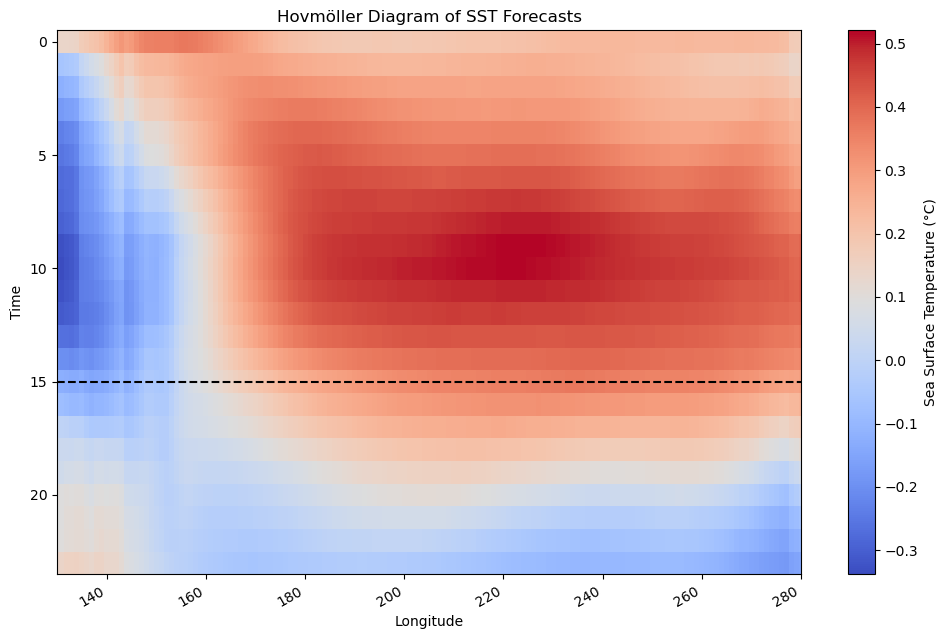

In [231]:
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs

# Extract the SST variable (replace 'sst' with the appropriate variable name)
sst = average_sst_GALL.unstack()

# Assume 'sst' has dimensions (time, latitude, longitude)
# Select a latitude range (e.g., near the equator for simplicity)
# Adjust latitude range based on your data
lat_range = slice(-10, 10)
sst_equator = sst.sel(lat=lat_range).mean(dim='lat')

# Create a Hovmöller diagram
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the data using pcolormesh or contourf
c = ax.pcolormesh(sst_equator_GALL.lon, sst_equator_GALL.time, sst_equator_GALL, cmap='coolwarm')

# Add color bar
cb = plt.colorbar(c, ax=ax, orientation='vertical')
cb.set_label('Sea Surface Temperature (°C)')

# Set labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Time')
ax.set_title('Hovmöller Diagram of SST Forecasts')
ax.set_xlim(130, 280)
ax.axhline(y=15, color='k', linestyle='--')
plt.gca().invert_yaxis()

# Adjust the date format on the y-axis if necessary
fig.autofmt_xdate()

# Show the plot
plt.show()

In [48]:
# Extract the SST variable (replace 'sst' with the appropriate variable name)
lat_range = slice(-10, 10)
sst_equator_GALL = average_sst_GALL.unstack().sel(lat=lat_range).mean(dim='lat')
sst_equator_POLY = average_sst_POLY.unstack().sel(lat=lat_range).mean(dim='lat')

average_sst_OBS=xr.zeros_like(average_sst_GALL.unstack())

for i in range(24):
    average_sst_OBS[i, :, :] = X_tos.A.unstack().isel(time=np.where(extreme_niño)[0][4::]-15+i).mean(dim='time').data

sst_equator_OBS = average_sst_OBS.unstack().sel(lat=lat_range).mean(dim='lat')


In [232]:
average_sst_OBS.unstack().sel(lat=slice(-5,5),lon=slice(170,200)).mean(dim=('lat','lon'))

<xarray.DataArray (time: 24)>
array([ 0.19374763,  0.28493633,  0.37793879,  0.4888948 ,  0.63174196,
        0.78235658,  0.94161015,  1.10725433,  1.26310921,  1.42396696,
        1.58593965,  1.75549549,  1.87382228,  1.81685567,  1.65638012,
        1.45960655,  1.24452607,  1.01251881,  0.73144154,  0.40355583,
        0.0842573 , -0.20688883, -0.49827405, -0.77278823])
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23

In [233]:
average_sst_GALL.unstack().sel(lat=slice(-5,5),lon=slice(170,200)).mean(dim=('lat','lon'))

<xarray.DataArray (time: 24)>
array([-0.03057533,  0.04106983,  0.12437089,  0.1930189 ,  0.25305025,
        0.30059776,  0.33400654,  0.36456359,  0.39146706,  0.41749595,
        0.43041297,  0.42649479,  0.41251498,  0.39686419,  0.37060779,
        0.33696775,  0.31514679,  0.27991564,  0.23221234,  0.18207759,
        0.13471367,  0.08619325,  0.04346832,  0.00319798])
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23

In [234]:
average_sst_POLY.unstack().sel(lat=slice(-5,5),lon=slice(170,200)).mean(dim=('lat','lon'))

<xarray.DataArray (time: 24)>
array([0.01847356, 0.0841905 , 0.14662135, 0.2034893 , 0.25338321,
       0.2954673 , 0.32928634, 0.3546479 , 0.37155986, 0.3802026 ,
       0.38091852, 0.37420664, 0.36071409, 0.3412209 , 0.31661707,
       0.28787325, 0.25600731, 0.22204948, 0.18700862, 0.1518417 ,
       0.11742799, 0.08454862, 0.05387208, 0.0259453 ])
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23

In [56]:
obs_lim= max(sst_equator_OBS.max(), -sst_equator_OBS.min())+0.25
for_lim= max(sst_equator_GALL.max(),sst_equator_POLY.max(), -sst_equator_GALL.min(), -sst_equator_POLY.min())+0.08

In [57]:
print(obs_lim)
print(for_lim)

<xarray.DataArray ()>
array(2.49867498)
<xarray.DataArray ()>
array(0.44320169)


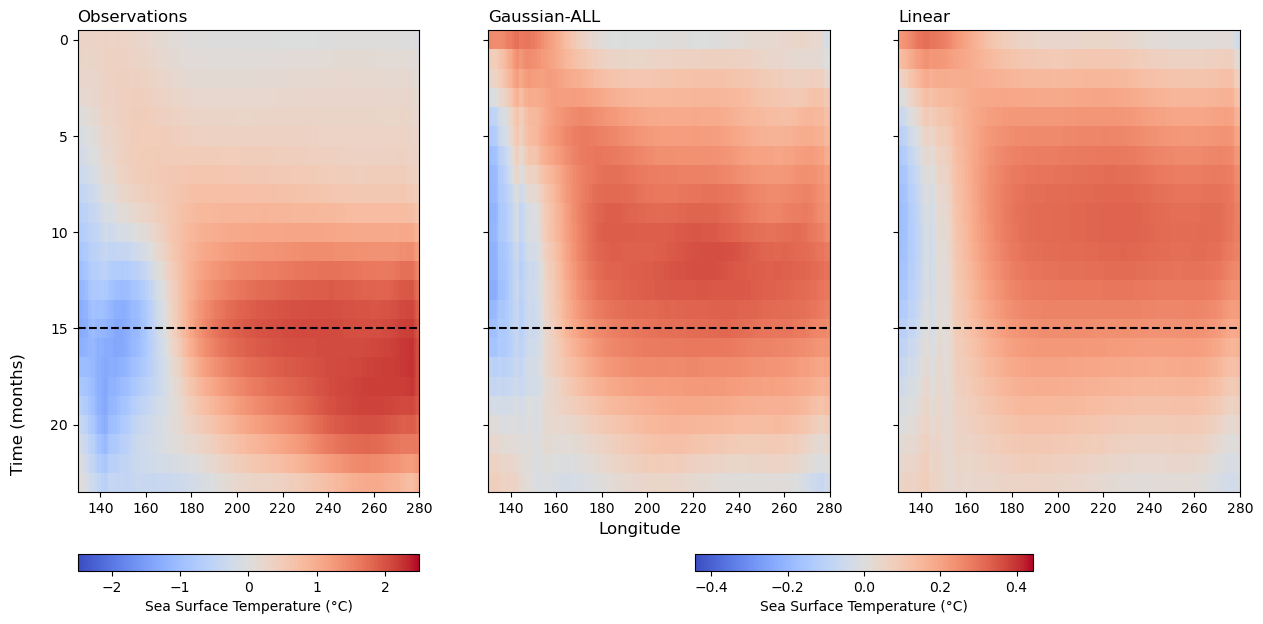

In [58]:
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs

# Extract the SST variable (replace 'sst' with the appropriate variable name)
sst = average_sst_GALL.unstack()

# Assume 'sst' has dimensions (time, latitude, longitude)
# Select a latitude range (e.g., near the equator for simplicity)
# Adjust latitude range based on your data
lat_range = slice(-10, 10)
sst_equator = sst.sel(lat=lat_range).mean(dim='lat')

# Create a Hovmöller diagram
fig, ax = plt.subplots(1, 3, figsize=(15, 8), sharex=True, sharey=True)

# Plot the data using pcolormesh
c0 = ax[0].pcolormesh(sst_equator_OBS.lon, sst_equator_OBS.time, sst_equator_OBS, cmap='coolwarm', vmin=-obs_lim, vmax=obs_lim)
c1 = ax[1].pcolormesh(sst_equator_GALL.lon, sst_equator_GALL.time, sst_equator_GALL, cmap='coolwarm', vmin=-for_lim, vmax=for_lim)
c2 = ax[2].pcolormesh(sst_equator_POLY.lon, sst_equator_POLY.time, sst_equator_POLY, cmap='coolwarm',  vmin=-for_lim, vmax=for_lim)

# Add color bars
cb0 = fig.colorbar(c0, ax=ax[0], orientation='horizontal', shrink=1, pad=0.1)
cb0.set_label('Sea Surface Temperature (°C)')

cb1 = fig.colorbar(c1, ax=ax[1:], orientation='horizontal', shrink=0.45, pad=0.1)
cb1.set_label('Sea Surface Temperature (°C)')

# Set titles for each subplot
ax[0].set_title('Observations', loc='left')
ax[1].set_title('Gaussian-ALL', loc='left')
ax[2].set_title('Linear', loc='left')

# Set labels and title
fig.text(0.5, 0.25, 'Longitude', ha='center',fontsize='large')
fig.text(0.08, 0.4, 'Time (months)', va='center', rotation='vertical',fontsize='large')

ax[0].set_xlim(130, 280)
ax[1].set_xlim(130, 280)
ax[2].set_xlim(130, 280)
ax[0].axhline(y=15, color='k', linestyle='--')
ax[1].axhline(y=15, color='k', linestyle='--')
ax[2].axhline(y=15, color='k', linestyle='--')
plt.gca().invert_yaxis()

# Adjust the date format on the y-axis if necessary
fig.autofmt_xdate()

# Show the plot
plt.show()

# Composite strong EL Niño cases 12 months

In [200]:
cstr_GALL=np.zeros((np.where(extreme_niño)[0][4::].shape[0],24))
cstr_POLY= np.zeros((np.where(extreme_niño)[0][4::].shape[0],24))

In [201]:
## Load EOFs
PCs=np.load('Processed_data/PCs_CESM_845SST_1000SSH.npy')
EOFs=np.load('Processed_data/EOFs_CESM_845SST_1000SSH.npy')

In [202]:
periods=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
lead_times=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
leads=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]

### ALL GAUSS

In [40]:
#Select EOFs
udat_sst=EOFs[:,0:845]

In [41]:
## Compute observations NON truncated to PCs
Obs=X_tos.A.unstack()

In [42]:
### Load data

tot_for=np.zeros((20, 17, 1845, 24, 1176))

for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 200/ALLEOFs_forecast_p{n}.npy')

tot_for_unionG=np.empty((17, 1845, 24, 24000))
tot_for_unionG.fill(np.NaN)

for m in lead_times:
    for n in periods:
        tot_for_unionG[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]

In [43]:
tot_for_unionG=tot_for_unionG[(0,2,4,6,8,10,12,14,16),:,:,:]
tot_for_unionG.shape

(9, 1845, 24, 24000)

### POLY

In [44]:
#Select EOFs
udat_sst=EOFs[:,0:845]

In [45]:
## Compute observations NON truncated to PCs
Obs=X_tos.A.unstack()

In [46]:
### Load data

tot_for=np.zeros((20, 17, 30, 24, 1176))

for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 200/POLY_forecast_p{n}.npy')

tot_for_unionP=np.empty((17, 30, 24, 24000))
tot_for_unionP.fill(np.NaN)

for m in lead_times:
    for n in periods:
        tot_for_unionP[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]

In [47]:
tot_for_unionP=tot_for_unionP[(0,2,4,6,8,10,12,14,16),:,:,:]
tot_for_unionP.shape

(9, 30, 24, 24000)

### CORRELATIONS

In [203]:
# Gaussian ALL
av_for_geo_ALL = xr.DataArray(
    data=None,
    dims=["z", "time", "init"],
    coords=dict(
        z=(X_tos.A.z),
        time=range(0,24),
        init=range(0,np.where(extreme_niño)[0][4::].shape[0]),
     ),
)

av_forALL=np.mean(tot_for_unionG, axis=0)

# Poly
av_for_geo_POLY = xr.DataArray(
    data=None,
    dims=["z", "time", "init"],
    coords=dict(
        z=(X_tos.A.z),
        time=range(0,24),
        init=range(0,np.where(extreme_niño)[0][4::].shape[0]),
     ),
)
av_forP=np.mean(tot_for_unionP, axis=0)

In [204]:
for j in range(np.where(extreme_niño)[0][4::].shape[0]):

    time_init=np.where(extreme_niño)[0][4::][j]-12
    X_tos.A[:, time_init]   # Inizia a JAN, max 20841 (NOV)
    
    # Gaussian ALL
    for n in range(24):
        lead=leads[n]
        av_for_geo_array=udat_sst @ av_forALL[0:845,lead,time_init+lead]            
        av_for_geo_ALL[:,n,j]=av_for_geo_array.real
    
    # Poly
    for n in range(24):
        lead=leads[n]
        av_for_geo_array=udat_sst[:,0:20] @ av_forP[0:20,lead,time_init+lead]            
        av_for_geo_POLY[:,n,j]=av_for_geo_array.real
    
    for i in range(24):
        corr=np.corrcoef(X_tos.A.isel(time=time_init+i),av_for_geo_ALL.isel(time=i).isel(init=j).astype(float))[0,1]
        cstr_GALL[j, i]=corr
    
    for i in range(24):
        corr=np.corrcoef(X_tos.A.isel(time=time_init+i),av_for_geo_POLY.isel(time=i).isel(init=j).astype(float))[0,1]
        cstr_POLY[j, i]=corr

In [205]:
np.nanmean(cstr_GALL, axis=0)

array([0.97573063, 0.72501462, 0.58921824, 0.5358303 , 0.50459265,
       0.48823177, 0.49479797, 0.51040907, 0.542751  , 0.56943836,
       0.59351814, 0.6010504 , 0.60631465, 0.58824509, 0.56986337,
       0.53662946, 0.49820716, 0.45048024, 0.41003722, 0.37170475,
       0.3263554 , 0.30451339, 0.27875222, 0.26715417])

In [206]:
np.nanmean(cstr_POLY, axis=0)

array([0.86892437, 0.72837772, 0.5920231 , 0.51538277, 0.46930555,
       0.44371115, 0.43753669, 0.44770038, 0.46214126, 0.47254912,
       0.48339015, 0.49468903, 0.49738711, 0.48475622, 0.45852236,
       0.42237096, 0.38015209, 0.33083697, 0.28332212, 0.24854546,
       0.2177182 , 0.19783012, 0.19059737, 0.17835607])

### Plot

In [207]:
average_sst_GALL=av_for_geo_ALL.mean(dim='init')
average_sst_GALL

<xarray.DataArray (z: 9121, time: 24)>
array([[-1.82644248e-01, -1.50448283e-01, -1.36733898e-01, ...,
         2.40484030e-01,  2.27286062e-01,  1.93064340e-01],
       [-1.99153986e-01, -1.64254667e-01, -1.37532676e-01, ...,
         2.52072382e-01,  2.47381791e-01,  2.14326148e-01],
       [-2.17824016e-01, -1.86589971e-01, -1.48953764e-01, ...,
         2.50955969e-01,  2.57107031e-01,  2.28409928e-01],
       ...,
       [-1.23359840e-02,  2.58302967e-02,  2.79016269e-02, ...,
         7.47441685e-02,  5.90834379e-02,  1.84574324e-02],
       [-5.56532499e-03,  2.75993805e-02,  3.26976679e-02, ...,
         6.34730296e-02,  4.69300334e-02,  9.11132785e-03],
       [ 4.85723058e-05,  2.93069686e-02,  3.61996383e-02, ...,
         5.39625205e-02,  3.69837739e-02,  1.90474271e-03]])
Coordinates:
  * z        (z) object MultiIndex
  * lat      (z) float64 -31.0 -31.0 -31.0 -31.0 -31.0 ... 32.0 32.0 32.0 32.0
  * lon      (z) int64 155 156 157 158 159 160 161 ... 285 286 287 288 289 290
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23

In [208]:
average_sst_POLY=av_for_geo_POLY.mean(dim='init')
average_sst_POLY

<xarray.DataArray (z: 9121, time: 24)>
array([[-0.06022202, -0.09161058, -0.10778041, ...,  0.11516362,
         0.10889662,  0.1005734 ],
       [-0.0683685 , -0.09620223, -0.10978196, ...,  0.12945892,
         0.1230653 ,  0.11443227],
       [-0.08380707, -0.10905097, -0.12089162, ...,  0.13570158,
         0.13018319,  0.12222847],
       ...,
       [ 0.0949325 ,  0.1034743 ,  0.098401  , ...,  0.01042301,
         0.01531219,  0.01958078],
       [ 0.09553676,  0.10309126,  0.09749956, ...,  0.00288231,
         0.00781831,  0.01225818],
       [ 0.09513077,  0.10205555,  0.09627673, ..., -0.00210165,
         0.00272605,  0.00715749]])
Coordinates:
  * z        (z) object MultiIndex
  * lat      (z) float64 -31.0 -31.0 -31.0 -31.0 -31.0 ... 32.0 32.0 32.0 32.0
  * lon      (z) int64 155 156 157 158 159 160 161 ... 285 286 287 288 289 290
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23

 Opening figure , 5 rows and 3 cols 

Setting Fixed Contours
 Contouring from  -3.7   to 3.7  with interval   0.2
Setting Fixed Contours
 Contouring from  -3.7   to 3.7  with interval   0.2
Setting Fixed Contours
 Contouring from  -3.7   to 3.7  with interval   0.2
Setting Fixed Contours
 Contouring from  -3.7   to 3.7  with interval   0.2
Setting Fixed Contours
 Contouring from  -3.7   to 3.7  with interval   0.2
Setting Fixed Contours
 Contouring from  -0.8   to 0.8  with interval   0.1
Setting Fixed Contours
 Contouring from  -0.8   to 0.8  with interval   0.1
Setting Fixed Contours
 Contouring from  -0.8   to 0.8  with interval   0.1
Setting Fixed Contours
 Contouring from  -0.8   to 0.8  with interval   0.1
Setting Fixed Contours
 Contouring from  -0.8   to 0.8  with interval   0.1
Setting Fixed Contours
 Contouring from  -0.8   to 0.8  with interval   0.1
Setting Fixed Contours
 Contouring from  -0.8   to 0.8  with interval   0.1
Setting Fixed Contours
 Contouring from  -0.8   to

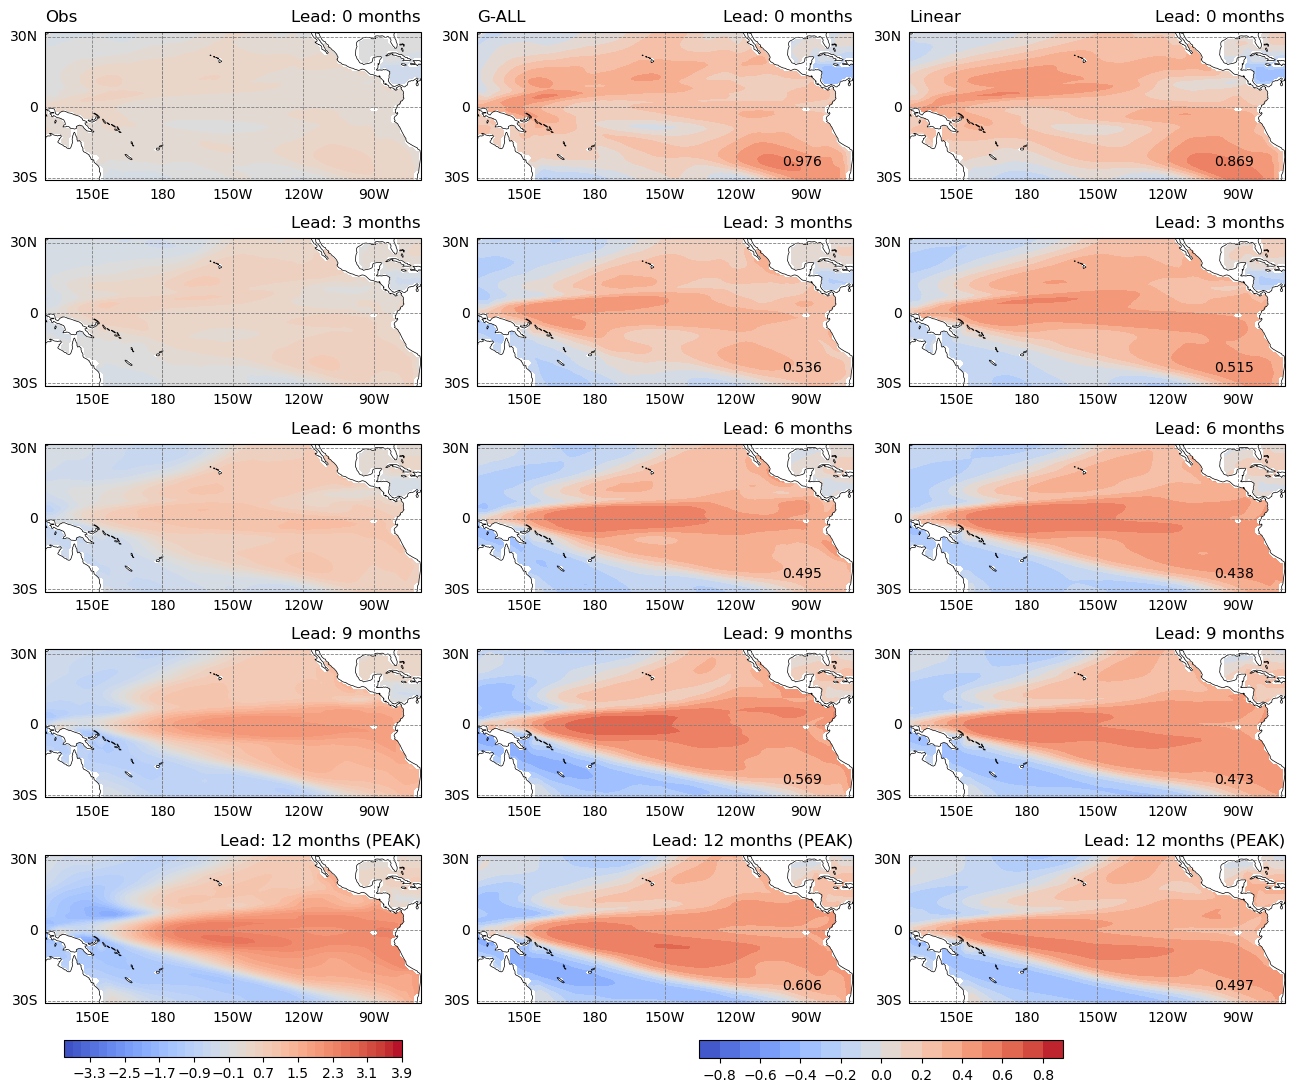

In [219]:
columns = 3
rows = 5
cont=[-3.7,3.7,0.2]
cont1=[-0.8,0.8,0.1]

fig,ax,pro=zmap.init_figure(rows,columns,'Pacific', constrained_layout=False, figsize=(16,16), sharex=True, sharey=True )

axh=ax[0,0]


#Observations
handle=zmap.xmap(X_tos.A.unstack().isel(time=np.where(extreme_niño)[0][4::]-12).mean(dim='time'),cont, pro, ax=ax[0,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 0 months', 'lefttitle':'Obs','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(X_tos.A.unstack().isel(time=np.where(extreme_niño)[0][4::]+1*3-12).mean(dim='time'),cont, pro, ax=ax[1,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 3 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(X_tos.A.unstack().isel(time=np.where(extreme_niño)[0][4::]+2*3-12).mean(dim='time'),cont, pro, ax=ax[2,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 6 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(X_tos.A.unstack().isel(time=np.where(extreme_niño)[0][4::]+3*3-12).mean(dim='time'),cont, pro, ax=ax[3,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 9 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(X_tos.A.unstack().isel(time=np.where(extreme_niño)[0][4::]+4*3-12).mean(dim='time'),cont, pro, ax=ax[4,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 12 months (PEAK)' , 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))


# G-ALL
handle1=zmap.xmap(average_sst_GALL.unstack().isel(time=0),cont1, pro, ax=ax[0,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 0 months', 'lefttitle':'G-ALL','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_GALL.unstack().isel(time=3),cont1, pro, ax=ax[1,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 3 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_GALL.unstack().isel(time=6),cont1, pro, ax=ax[2,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 6 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_GALL.unstack().isel(time=9),cont1, pro, ax=ax[3,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 9 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_GALL.unstack().isel(time=12),cont1, pro, ax=ax[4,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 12 months (PEAK)', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))


# POLY
handle1=zmap.xmap(average_sst_POLY.unstack().isel(time=0),cont1, pro, ax=ax[0,2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 0 months', 'lefttitle':'Linear','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_POLY.unstack().isel(time=3),cont1, pro, ax=ax[1,2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 3 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_POLY.unstack().isel(time=6),cont1, pro, ax=ax[2,2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 6 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_POLY.unstack().isel(time=9),cont1, pro, ax=ax[3,2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 9 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_POLY.unstack().isel(time=12),cont1, pro, ax=ax[4,2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 12 months (PEAK)', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))


ax[0,1].text(80,-25,np.around(np.nanmean(cstr_GALL, axis=0)[0], decimals=3))
ax[1,1].text(80,-25,np.around(np.nanmean(cstr_GALL, axis=0)[3], decimals=3))
ax[2,1].text(80,-25,np.around(np.nanmean(cstr_GALL, axis=0)[6], decimals=3))
ax[3,1].text(80,-25,np.around(np.nanmean(cstr_GALL, axis=0)[9], decimals=3))
ax[4,1].text(80,-25,np.around(np.nanmean(cstr_GALL, axis=0)[12], decimals=3))
ax[0,2].text(80,-25,np.around(np.nanmean(cstr_POLY, axis=0)[0], decimals=3))
ax[1,2].text(80,-25,np.around(np.nanmean(cstr_POLY, axis=0)[3], decimals=3))
ax[2,2].text(80,-25,np.around(np.nanmean(cstr_POLY, axis=0)[6], decimals=3))
ax[3,2].text(80,-25,np.around(np.nanmean(cstr_POLY, axis=0)[9], decimals=3))
ax[4,2].text(80,-25,np.around(np.nanmean(cstr_POLY, axis=0)[12], decimals=3))

axh.xaxis.set_tick_params(labelbottom=True)
zmap.changelabel(axh,fontsize=14,fontfamily='Futura',fontweight='bold')
zmap.changebox(axh,'all',linewidth=1.5)  
        
plt.subplots_adjust(wspace=0.15,hspace=0.1)
fig.colorbar(handle['filled'], ax=ax[:, 0],shrink=0.9, orientation = 'horizontal',pad=0.03)
fig.colorbar(handle1['filled'], ax=ax[:, 1:3],shrink=0.45, orientation = 'horizontal',pad=0.03)
plt.savefig('Ex1.pdf', orientation='landscape',  format='pdf')
plt.savefig('Ex1.jpg', orientation='landscape',  format='jpg')


plt.show()

In [210]:
# Extract the SST variable (replace 'sst' with the appropriate variable name)
lat_range = slice(-10, 10)
sst_equator_GALL = average_sst_GALL.unstack().sel(lat=lat_range).mean(dim='lat')
sst_equator_POLY = average_sst_POLY.unstack().sel(lat=lat_range).mean(dim='lat')

average_sst_OBS=xr.zeros_like(average_sst_GALL.unstack())

for i in range(24):
    average_sst_OBS[i, :, :] = X_tos.A.unstack().isel(time=np.where(extreme_niño)[0][4::]-12+i).mean(dim='time').data

sst_equator_OBS = average_sst_OBS.unstack().sel(lat=lat_range).mean(dim='lat')


In [213]:
average_sst_OBS.unstack().sel(lat=slice(-5,5),lon=slice(170,200)).mean(dim=('lat','lon'))

<xarray.DataArray (time: 24)>
array([ 0.19374763,  0.28493633,  0.37793879,  0.4888948 ,  0.63174196,
        0.78235658,  0.94161015,  1.10725433,  1.26310921,  1.42396696,
        1.58593965,  1.75549549,  1.87382228,  1.81685567,  1.65638012,
        1.45960655,  1.24452607,  1.01251881,  0.73144154,  0.40355583,
        0.0842573 , -0.20688883, -0.49827405, -0.77278823])
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23

In [214]:
average_sst_GALL.unstack().sel(lat=slice(-5,5),lon=slice(170,200)).mean(dim=('lat','lon'))

<xarray.DataArray (time: 24)>
array([ 0.1892993 ,  0.26588488,  0.3421238 ,  0.40617351,  0.46365478,
        0.50841428,  0.54736258,  0.577779  ,  0.58951317,  0.59187359,
        0.58697631,  0.56226115,  0.52165945,  0.47823492,  0.42362186,
        0.36463651,  0.31941036,  0.25962005,  0.18598009,  0.11584724,
        0.05595272, -0.0035662 , -0.05902252, -0.10478496])
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23

In [215]:
average_sst_POLY.unstack().sel(lat=slice(-5,5),lon=slice(170,200)).mean(dim=('lat','lon'))

<xarray.DataArray (time: 24)>
array([ 0.23799223,  0.31212101,  0.37756767,  0.43304675,  0.47788961,
        0.51180581,  0.53475647,  0.54690186,  0.54859032,  0.54036357,
        0.52296108,  0.49731421,  0.4645263 ,  0.42583954,  0.38259176,
        0.33616763,  0.28794866,  0.23926607,  0.19135944,  0.14534297,
        0.10218047,  0.06266899,  0.02743064, -0.0030883 ])
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23

In [211]:
obs_lim= max(sst_equator_OBS.max(), -sst_equator_OBS.min())
for_lim= max(sst_equator_GALL.max(),sst_equator_POLY.max(), -sst_equator_GALL.min(), -sst_equator_POLY.min())

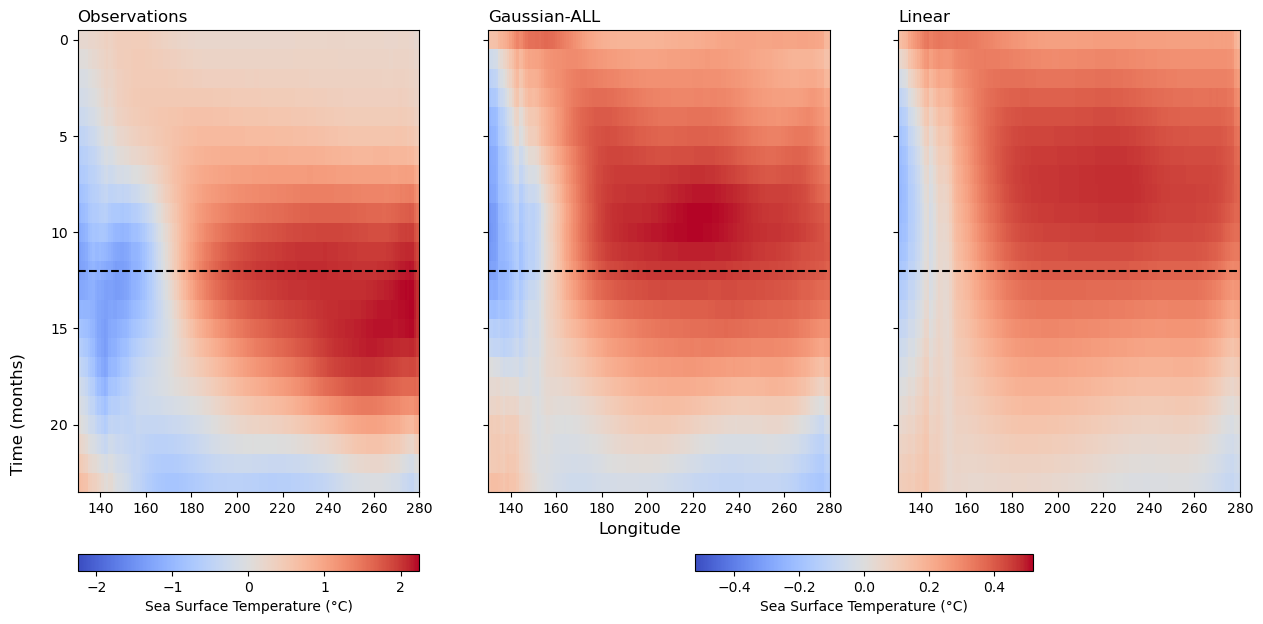

In [212]:
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs

# Extract the SST variable (replace 'sst' with the appropriate variable name)
sst = average_sst_GALL.unstack()

# Assume 'sst' has dimensions (time, latitude, longitude)
# Select a latitude range (e.g., near the equator for simplicity)
# Adjust latitude range based on your data
lat_range = slice(-10, 10)
sst_equator = sst.sel(lat=lat_range).mean(dim='lat')

# Create a Hovmöller diagram
fig, ax = plt.subplots(1, 3, figsize=(15, 8), sharex=True, sharey=True)

# Plot the data using pcolormesh
c0 = ax[0].pcolormesh(sst_equator_OBS.lon, sst_equator_OBS.time, sst_equator_OBS, cmap='coolwarm', vmin=-obs_lim, vmax=obs_lim)
c1 = ax[1].pcolormesh(sst_equator_GALL.lon, sst_equator_GALL.time, sst_equator_GALL, cmap='coolwarm', vmin=-for_lim, vmax=for_lim)
c2 = ax[2].pcolormesh(sst_equator_POLY.lon, sst_equator_POLY.time, sst_equator_POLY, cmap='coolwarm',  vmin=-for_lim, vmax=for_lim)

# Add color bars
cb0 = fig.colorbar(c0, ax=ax[0], orientation='horizontal', shrink=1, pad=0.1)
cb0.set_label('Sea Surface Temperature (°C)')

cb1 = fig.colorbar(c1, ax=ax[1:], orientation='horizontal', shrink=0.45, pad=0.1)
cb1.set_label('Sea Surface Temperature (°C)')

# Set titles for each subplot
ax[0].set_title('Observations', loc='left')
ax[1].set_title('Gaussian-ALL', loc='left')
ax[2].set_title('Linear', loc='left')

# Set labels and title
fig.text(0.5, 0.25, 'Longitude', ha='center',fontsize='large')
fig.text(0.08, 0.4, 'Time (months)', va='center', rotation='vertical',fontsize='large')

ax[0].set_xlim(130, 280)
ax[1].set_xlim(130, 280)
ax[2].set_xlim(130, 280)
ax[0].axhline(y=12, color='k', linestyle='--')
ax[1].axhline(y=12, color='k', linestyle='--')
ax[2].axhline(y=12, color='k', linestyle='--')
plt.gca().invert_yaxis()

# Adjust the date format on the y-axis if necessary
fig.autofmt_xdate()

# Show the plot
plt.show()

# Composite strong La Niña cases 10 months

In [154]:
cstr_GALL=np.zeros((np.where(extreme_niña)[0][:-1].shape[0],24))
cstr_POLY= np.zeros((np.where(extreme_niña)[0][:-1].shape[0],24))

In [146]:
## Load EOFs
PCs=np.load('Processed_data/PCs_CESM_845SST_1000SSH.npy')
EOFs=np.load('Processed_data/EOFs_CESM_845SST_1000SSH.npy')

In [147]:
periods=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
lead_times=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
leads=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]

### ALL GAUSS

In [40]:
#Select EOFs
udat_sst=EOFs[:,0:845]

In [41]:
## Compute observations NON truncated to PCs
Obs=X_tos.A.unstack()

In [42]:
### Load data

tot_for=np.zeros((20, 17, 1845, 24, 1176))

for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 200/ALLEOFs_forecast_p{n}.npy')

tot_for_unionG=np.empty((17, 1845, 24, 24000))
tot_for_unionG.fill(np.NaN)

for m in lead_times:
    for n in periods:
        tot_for_unionG[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]

In [43]:
tot_for_unionG=tot_for_unionG[(0,2,4,6,8,10,12,14,16),:,:,:]
tot_for_unionG.shape

(9, 1845, 24, 24000)

### POLY

In [44]:
#Select EOFs
udat_sst=EOFs[:,0:845]

In [45]:
## Compute observations NON truncated to PCs
Obs=X_tos.A.unstack()

In [46]:
### Load data

tot_for=np.zeros((20, 17, 30, 24, 1176))

for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 200/POLY_forecast_p{n}.npy')

tot_for_unionP=np.empty((17, 30, 24, 24000))
tot_for_unionP.fill(np.NaN)

for m in lead_times:
    for n in periods:
        tot_for_unionP[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]

In [47]:
tot_for_unionP=tot_for_unionP[(0,2,4,6,8,10,12,14,16),:,:,:]
tot_for_unionP.shape

(9, 30, 24, 24000)

### CORRELATIONS

In [148]:
# Gaussian ALL
av_for_geo_ALL = xr.DataArray(
    data=None,
    dims=["z", "time", "init"],
    coords=dict(
        z=(X_tos.A.z),
        time=range(0,24),
        init=range(0,np.where(extreme_niña)[0][:-1].shape[0]),
     ),
)

av_forALL=np.mean(tot_for_unionG, axis=0)

# Poly
av_for_geo_POLY = xr.DataArray(
    data=None,
    dims=["z", "time", "init"],
    coords=dict(
        z=(X_tos.A.z),
        time=range(0,24),
        init=range(0,np.where(extreme_niña)[0][:-1].shape[0]),
     ),
)
av_forP=np.mean(tot_for_unionP, axis=0)

In [155]:
for j in range(np.where(extreme_niña)[0][:-1].shape[0]):

    time_init=np.where(extreme_niña)[0][:-1][j]-10
    X_tos.A[:, time_init]   # Inizia a JAN, max 20841 (NOV)
    
    # Gaussian ALL
    for n in range(24):
        lead=leads[n]
        av_for_geo_array=udat_sst @ av_forALL[0:845,lead,time_init+lead]            
        av_for_geo_ALL[:,n,j]=av_for_geo_array.real
    
    # Poly
    for n in range(24):
        lead=leads[n]
        av_for_geo_array=udat_sst[:,0:20] @ av_forP[0:20,lead,time_init+lead]            
        av_for_geo_POLY[:,n,j]=av_for_geo_array.real
    
    for i in range(24):
        corr=np.corrcoef(X_tos.A.isel(time=time_init+i),av_for_geo_ALL.isel(time=i).isel(init=j).astype(float))[0,1]
        cstr_GALL[j, i]=corr
    
    for i in range(24):
        corr=np.corrcoef(X_tos.A.isel(time=time_init+i),av_for_geo_POLY.isel(time=i).isel(init=j).astype(float))[0,1]
        cstr_POLY[j, i]=corr

In [156]:
np.nanmean(cstr_GALL, axis=0)

array([0.97123456, 0.84600117, 0.80642056, 0.78696639, 0.77281214,
       0.76355572, 0.7495204 , 0.74697702, 0.74748429, 0.75307546,
       0.76259966, 0.77632598, 0.77822119, 0.7761416 , 0.77466478,
       0.76497875, 0.75190922, 0.73152016, 0.69338702, 0.65176027,
       0.60929767, 0.58082234, 0.56082389, 0.53836639])

In [157]:
np.nanmean(cstr_POLY, axis=0)

array([0.90890132, 0.83781276, 0.77558288, 0.72833593, 0.68496353,
       0.64891084, 0.61104224, 0.58079122, 0.56851642, 0.57130025,
       0.58166567, 0.59646336, 0.60835255, 0.61316723, 0.61855114,
       0.62219524, 0.61739028, 0.60382953, 0.57143036, 0.53299789,
       0.49345905, 0.46574868, 0.44535792, 0.42376468])

### Plot

In [158]:
average_sst_GALL=av_for_geo_ALL.mean(dim='init')
average_sst_GALL

<xarray.DataArray (z: 9121, time: 24)>
array([[ 3.17089125e-01,  4.12766100e-01,  4.61222136e-01, ...,
        -2.02145084e-01, -2.21546372e-01, -2.57900647e-01],
       [ 3.33652083e-01,  4.25713978e-01,  4.68775845e-01, ...,
        -2.10344315e-01, -2.41983418e-01, -2.89770818e-01],
       [ 3.32597473e-01,  4.23829061e-01,  4.64113871e-01, ...,
        -1.96265726e-01, -2.35539534e-01, -2.96400594e-01],
       ...,
       [-5.65935655e-02, -8.40497216e-02, -8.93588055e-02, ...,
         2.56747198e-04, -4.54426947e-02, -1.14624149e-02],
       [-5.38525313e-02, -8.02500136e-02, -8.77909270e-02, ...,
         1.24684149e-02, -3.02506918e-02,  4.77342170e-03],
       [-5.00980526e-02, -7.62535268e-02, -8.50707953e-02, ...,
         2.07996971e-02, -1.97911274e-02,  1.58297840e-02]])
Coordinates:
  * z        (z) object MultiIndex
  * lat      (z) float64 -31.0 -31.0 -31.0 -31.0 -31.0 ... 32.0 32.0 32.0 32.0
  * lon      (z) int64 155 156 157 158 159 160 161 ... 285 286 287 288 289 290
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23

In [159]:
average_sst_POLY=av_for_geo_POLY.mean(dim='init')
average_sst_POLY

<xarray.DataArray (z: 9121, time: 24)>
array([[ 0.42246722,  0.46389102,  0.4917823 , ..., -0.25914183,
        -0.25894827, -0.25248378],
       [ 0.43974315,  0.48300201,  0.51212509, ..., -0.28274663,
        -0.28332181, -0.2771077 ],
       [ 0.438859  ,  0.48657158,  0.52022044, ..., -0.28902768,
        -0.29240474, -0.28854893],
       ...,
       [-0.2145332 , -0.1868993 , -0.13740449, ...,  0.03370217,
         0.01890117,  0.0048543 ],
       [-0.21834763, -0.19211272, -0.14484977, ...,  0.04683854,
         0.03264816,  0.01888975],
       [-0.21871952, -0.19392415, -0.14895481, ...,  0.0546216 ,
         0.04123433,  0.02803743]])
Coordinates:
  * z        (z) object MultiIndex
  * lat      (z) float64 -31.0 -31.0 -31.0 -31.0 -31.0 ... 32.0 32.0 32.0 32.0
  * lon      (z) int64 155 156 157 158 159 160 161 ... 285 286 287 288 289 290
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23

 Opening figure , 7 rows and 3 cols 

Setting Fixed Contours
 Contouring from  -3.7   to 3.7  with interval   0.2
Setting Fixed Contours
 Contouring from  -3.7   to 3.7  with interval   0.2
Setting Fixed Contours
 Contouring from  -3.7   to 3.7  with interval   0.2
Setting Fixed Contours
 Contouring from  -3.7   to 3.7  with interval   0.2
Setting Fixed Contours
 Contouring from  -3.7   to 3.7  with interval   0.2
Setting Fixed Contours
 Contouring from  -3.7   to 3.7  with interval   0.2
Setting Fixed Contours
 Contouring from  -3.7   to 3.7  with interval   0.2
Setting Fixed Contours
 Contouring from  -1.9   to 1.9  with interval   0.1
Setting Fixed Contours
 Contouring from  -1.9   to 1.9  with interval   0.1
Setting Fixed Contours
 Contouring from  -1.9   to 1.9  with interval   0.1
Setting Fixed Contours
 Contouring from  -1.9   to 1.9  with interval   0.1
Setting Fixed Contours
 Contouring from  -1.9   to 1.9  with interval   0.1
Setting Fixed Contours
 Contouring from  -1.9   to

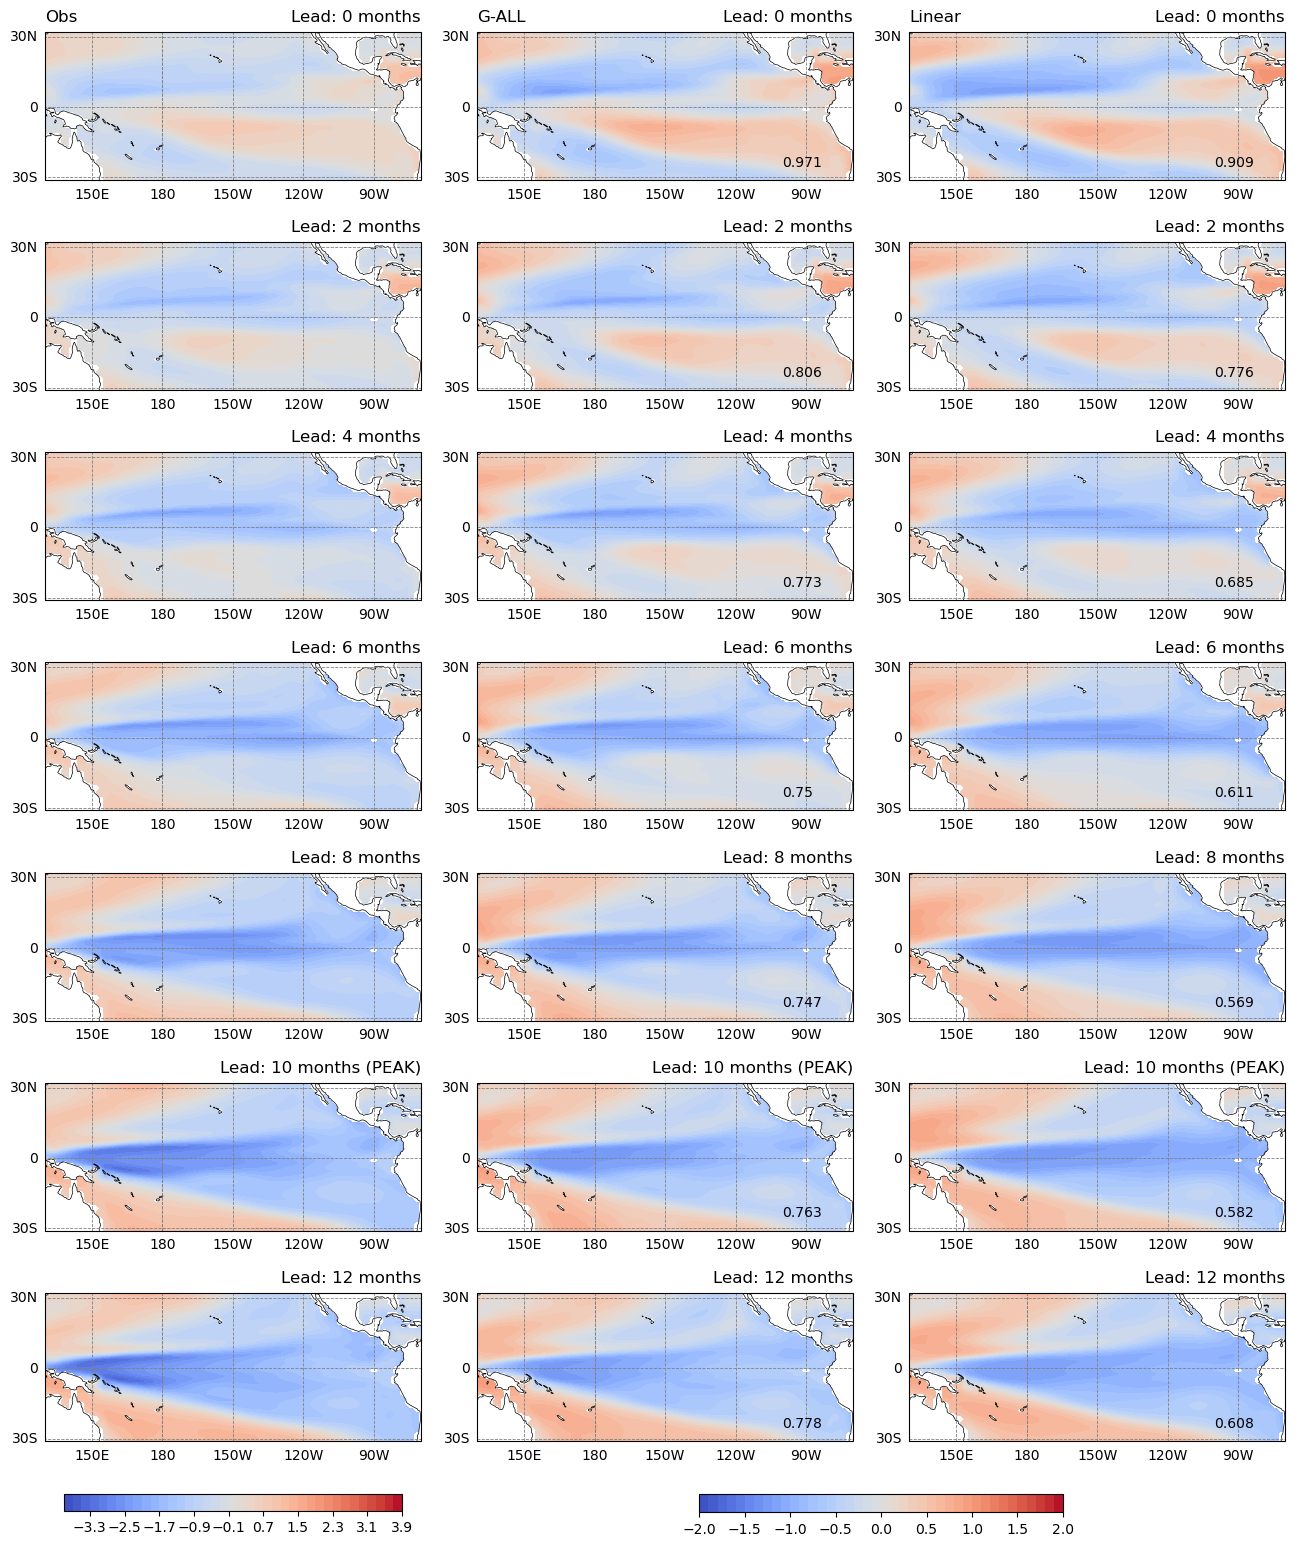

In [161]:
columns = 3
rows = 7
cont=[-3.7,3.7,0.2]
cont1=[-1.9,1.9,0.1]

fig,ax,pro=zmap.init_figure(rows,columns,'Pacific', constrained_layout=False, figsize=(16,23), sharex=True, sharey=True )

axh=ax[0,0]


#Observations
handle=zmap.xmap(X_tos.A.unstack().isel(time=np.where(extreme_niña)[0][:-1]-10).mean(dim='time'),cont, pro, ax=ax[0,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 0 months', 'lefttitle':'Obs','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(X_tos.A.unstack().isel(time=np.where(extreme_niña)[0][:-1]+1*2-10).mean(dim='time'),cont, pro, ax=ax[1,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 2 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(X_tos.A.unstack().isel(time=np.where(extreme_niña)[0][:-1]+2*2-10).mean(dim='time'),cont, pro, ax=ax[2,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 4 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(X_tos.A.unstack().isel(time=np.where(extreme_niña)[0][:-1]+3*2-10).mean(dim='time'),cont, pro, ax=ax[3,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 6 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(X_tos.A.unstack().isel(time=np.where(extreme_niña)[0][:-1]+4*2-10).mean(dim='time'),cont, pro, ax=ax[4,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 8 months' , 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(X_tos.A.unstack().isel(time=np.where(extreme_niña)[0][:-1]+5*2-10).mean(dim='time'),cont, pro, ax=ax[5,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 10 months (PEAK)', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(X_tos.A.unstack().isel(time=np.where(extreme_niña)[0][:-1]+6*2-10).mean(dim='time'),cont, pro, ax=ax[6,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 12 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))


# G-ALL
handle1=zmap.xmap(average_sst_GALL.unstack().isel(time=0),cont1, pro, ax=ax[0,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 0 months', 'lefttitle':'G-ALL','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_GALL.unstack().isel(time=2),cont1, pro, ax=ax[1,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 2 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_GALL.unstack().isel(time=4),cont1, pro, ax=ax[2,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 4 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_GALL.unstack().isel(time=6),cont1, pro, ax=ax[3,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 6 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_GALL.unstack().isel(time=8),cont1, pro, ax=ax[4,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 8 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_GALL.unstack().isel(time=10),cont1, pro, ax=ax[5,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 10 months (PEAK)', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_GALL.unstack().isel(time=12),cont1, pro, ax=ax[6,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 12 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))


# POLY
handle1=zmap.xmap(average_sst_POLY.unstack().isel(time=0),cont1, pro, ax=ax[0,2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 0 months', 'lefttitle':'Linear','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_POLY.unstack().isel(time=2),cont1, pro, ax=ax[1,2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 2 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_POLY.unstack().isel(time=4),cont1, pro, ax=ax[2,2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 4 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_POLY.unstack().isel(time=6),cont1, pro, ax=ax[3,2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 6 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_POLY.unstack().isel(time=8),cont1, pro, ax=ax[4,2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 8 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_POLY.unstack().isel(time=10),cont1, pro, ax=ax[5,2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 10 months (PEAK)', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_POLY.unstack().isel(time=12),cont1, pro, ax=ax[6,2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 12 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))


ax[0,1].text(80,-25,np.around(np.nanmean(cstr_GALL, axis=0)[0], decimals=3))
ax[1,1].text(80,-25,np.around(np.nanmean(cstr_GALL, axis=0)[2], decimals=3))
ax[2,1].text(80,-25,np.around(np.nanmean(cstr_GALL, axis=0)[4], decimals=3))
ax[3,1].text(80,-25,np.around(np.nanmean(cstr_GALL, axis=0)[6], decimals=3))
ax[4,1].text(80,-25,np.around(np.nanmean(cstr_GALL, axis=0)[8], decimals=3))
ax[5,1].text(80,-25,np.around(np.nanmean(cstr_GALL, axis=0)[10], decimals=3))
ax[6,1].text(80,-25,np.around(np.nanmean(cstr_GALL, axis=0)[12], decimals=3))
ax[0,2].text(80,-25,np.around(np.nanmean(cstr_POLY, axis=0)[0], decimals=3))
ax[1,2].text(80,-25,np.around(np.nanmean(cstr_POLY, axis=0)[2], decimals=3))
ax[2,2].text(80,-25,np.around(np.nanmean(cstr_POLY, axis=0)[4], decimals=3))
ax[3,2].text(80,-25,np.around(np.nanmean(cstr_POLY, axis=0)[6], decimals=3))
ax[4,2].text(80,-25,np.around(np.nanmean(cstr_POLY, axis=0)[8], decimals=3))
ax[5,2].text(80,-25,np.around(np.nanmean(cstr_POLY, axis=0)[10], decimals=3))
ax[6,2].text(80,-25,np.around(np.nanmean(cstr_POLY, axis=0)[12], decimals=3))

axh.xaxis.set_tick_params(labelbottom=True)
zmap.changelabel(axh,fontsize=14,fontfamily='Futura',fontweight='bold')
zmap.changebox(axh,'all',linewidth=1.5)  
        
plt.subplots_adjust(wspace=0.15,hspace=0.1)
fig.colorbar(handle['filled'], ax=ax[:, 0],shrink=0.9, orientation = 'horizontal',pad=0.03)
fig.colorbar(handle1['filled'], ax=ax[:, 1:3],shrink=0.45, orientation = 'horizontal',pad=0.03)
#plt.savefig('Fig 12.pdf', orientation='landscape',  format='pdf')
#plt.savefig('Fig 12.jpg', orientation='landscape',  format='jpg')


plt.show()

In [42]:
### Load data

tot_for=np.zeros((20, 17, 1845, 24, 1176))

for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 200/ALLEOFs_forecast_p{n}.npy')

tot_for_unionG=np.empty((17, 1845, 24, 24000))
tot_for_unionG.fill(np.NaN)

for m in lead_times:
    for n in periods:
        tot_for_unionG[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]

In [43]:
tot_for_unionG=tot_for_unionG[(0,2,4,6,8,10,12,14,16),:,:,:]
tot_for_unionG.shape

(9, 1845, 24, 24000)

In [44]:
#Select EOFs
udat_sst=EOFs[:,0:845]

In [45]:
## Compute observations NON truncated to PCs
Obs=X_tos.A.unstack()

In [46]:
### Load data

tot_for=np.zeros((20, 17, 30, 24, 1176))

for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 200/POLY_forecast_p{n}.npy')

tot_for_unionP=np.empty((17, 30, 24, 24000))
tot_for_unionP.fill(np.NaN)

for m in lead_times:
    for n in periods:
        tot_for_unionP[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]

In [47]:
tot_for_unionP=tot_for_unionP[(0,2,4,6,8,10,12,14,16),:,:,:]
tot_for_unionP.shape

(9, 30, 24, 24000)

# Composite strong La Niña cases 15 months

In [91]:
cstr_GALL=np.zeros((np.where(extreme_niña)[0][:-1].shape[0],24))
cstr_POLY= np.zeros((np.where(extreme_niña)[0][:-1].shape[0],24))

In [92]:
## Load EOFs
PCs=np.load('Processed_data/PCs_CESM_845SST_1000SSH.npy')
EOFs=np.load('Processed_data/EOFs_CESM_845SST_1000SSH.npy')

In [93]:
periods=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
lead_times=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
leads=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]

### ALL GAUSS

In [40]:
#Select EOFs
udat_sst=EOFs[:,0:845]

In [41]:
## Compute observations NON truncated to PCs
Obs=X_tos.A.unstack()

In [42]:
### Load data

tot_for=np.zeros((20, 17, 1845, 24, 1176))

for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 200/ALLEOFs_forecast_p{n}.npy')

tot_for_unionG=np.empty((17, 1845, 24, 24000))
tot_for_unionG.fill(np.NaN)

for m in lead_times:
    for n in periods:
        tot_for_unionG[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]

In [43]:
tot_for_unionG=tot_for_unionG[(0,2,4,6,8,10,12,14,16),:,:,:]
tot_for_unionG.shape

(9, 1845, 24, 24000)

### POLY

In [44]:
#Select EOFs
udat_sst=EOFs[:,0:845]

In [45]:
## Compute observations NON truncated to PCs
Obs=X_tos.A.unstack()

In [46]:
### Load data

tot_for=np.zeros((20, 17, 30, 24, 1176))

for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 200/POLY_forecast_p{n}.npy')

tot_for_unionP=np.empty((17, 30, 24, 24000))
tot_for_unionP.fill(np.NaN)

for m in lead_times:
    for n in periods:
        tot_for_unionP[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]

In [47]:
tot_for_unionP=tot_for_unionP[(0,2,4,6,8,10,12,14,16),:,:,:]
tot_for_unionP.shape

(9, 30, 24, 24000)

### CORRELATIONS

In [171]:
# Gaussian ALL
av_for_geo_ALL = xr.DataArray(
    data=None,
    dims=["z", "time", "init"],
    coords=dict(
        z=(X_tos.A.z),
        time=range(0,24),
        init=range(0,np.where(extreme_niña)[0][:-1].shape[0]),
     ),
)

av_forALL=np.mean(tot_for_unionG, axis=0)

# Poly
av_for_geo_POLY = xr.DataArray(
    data=None,
    dims=["z", "time", "init"],
    coords=dict(
        z=(X_tos.A.z),
        time=range(0,24),
        init=range(0,np.where(extreme_niña)[0][:-1].shape[0]),
     ),
)
av_forP=np.mean(tot_for_unionP, axis=0)

In [172]:
for j in range(np.where(extreme_niña)[0][:-1].shape[0]):

    time_init=np.where(extreme_niña)[0][:-1][j]-15
    X_tos.A[:, time_init]   # Inizia a JAN, max 20841 (NOV)
    
    # Gaussian ALL
    for n in range(24):
        lead=leads[n]
        av_for_geo_array=udat_sst @ av_forALL[0:845,lead,time_init+lead]            
        av_for_geo_ALL[:,n,j]=av_for_geo_array.real
    
    # Poly
    for n in range(24):
        lead=leads[n]
        av_for_geo_array=udat_sst[:,0:20] @ av_forP[0:20,lead,time_init+lead]            
        av_for_geo_POLY[:,n,j]=av_for_geo_array.real
    
    for i in range(24):
        corr=np.corrcoef(X_tos.A.isel(time=time_init+i),av_for_geo_ALL.isel(time=i).isel(init=j).astype(float))[0,1]
        cstr_GALL[j, i]=corr
    
    for i in range(24):
        corr=np.corrcoef(X_tos.A.isel(time=time_init+i),av_for_geo_POLY.isel(time=i).isel(init=j).astype(float))[0,1]
        cstr_POLY[j, i]=corr

In [173]:
np.nanmean(cstr_GALL, axis=0)

array([0.97453783, 0.83171413, 0.77076926, 0.73971305, 0.70791768,
       0.68043545, 0.65549573, 0.63668306, 0.61947554, 0.60350721,
       0.59804978, 0.60513024, 0.61004738, 0.62546599, 0.63644843,
       0.65418586, 0.67120092, 0.67932957, 0.67206994, 0.66281986,
       0.65161998, 0.64100108, 0.62577064, 0.59511023])

In [174]:
np.nanmean(cstr_POLY, axis=0)

array([0.90770553, 0.82377628, 0.74865479, 0.69696639, 0.64042828,
       0.58614114, 0.53788704, 0.49061061, 0.45085824, 0.41088099,
       0.37936642, 0.35153014, 0.33415535, 0.33390336, 0.34563987,
       0.36546124, 0.39049242, 0.41318603, 0.42445069, 0.43038103,
       0.43246486, 0.4289867 , 0.42476002, 0.40961647])

### Plot

In [175]:
average_sst_GALL=av_for_geo_ALL.mean(dim='init')

In [176]:
average_sst_POLY=av_for_geo_POLY.mean(dim='init')

 Opening figure , 7 rows and 3 cols 

Setting Fixed Contours
 Contouring from  -3.7   to 3.7  with interval   0.2
Setting Fixed Contours
 Contouring from  -3.7   to 3.7  with interval   0.2
Setting Fixed Contours
 Contouring from  -3.7   to 3.7  with interval   0.2
Setting Fixed Contours
 Contouring from  -3.7   to 3.7  with interval   0.2
Setting Fixed Contours
 Contouring from  -3.7   to 3.7  with interval   0.2
Setting Fixed Contours
 Contouring from  -3.7   to 3.7  with interval   0.2
Setting Fixed Contours
 Contouring from  -3.7   to 3.7  with interval   0.2
Setting Fixed Contours
 Contouring from  -1.5   to 1.5  with interval   0.1
Setting Fixed Contours
 Contouring from  -1.5   to 1.5  with interval   0.1
Setting Fixed Contours
 Contouring from  -1.5   to 1.5  with interval   0.1
Setting Fixed Contours
 Contouring from  -1.5   to 1.5  with interval   0.1
Setting Fixed Contours
 Contouring from  -1.5   to 1.5  with interval   0.1
Setting Fixed Contours
 Contouring from  -1.5   to

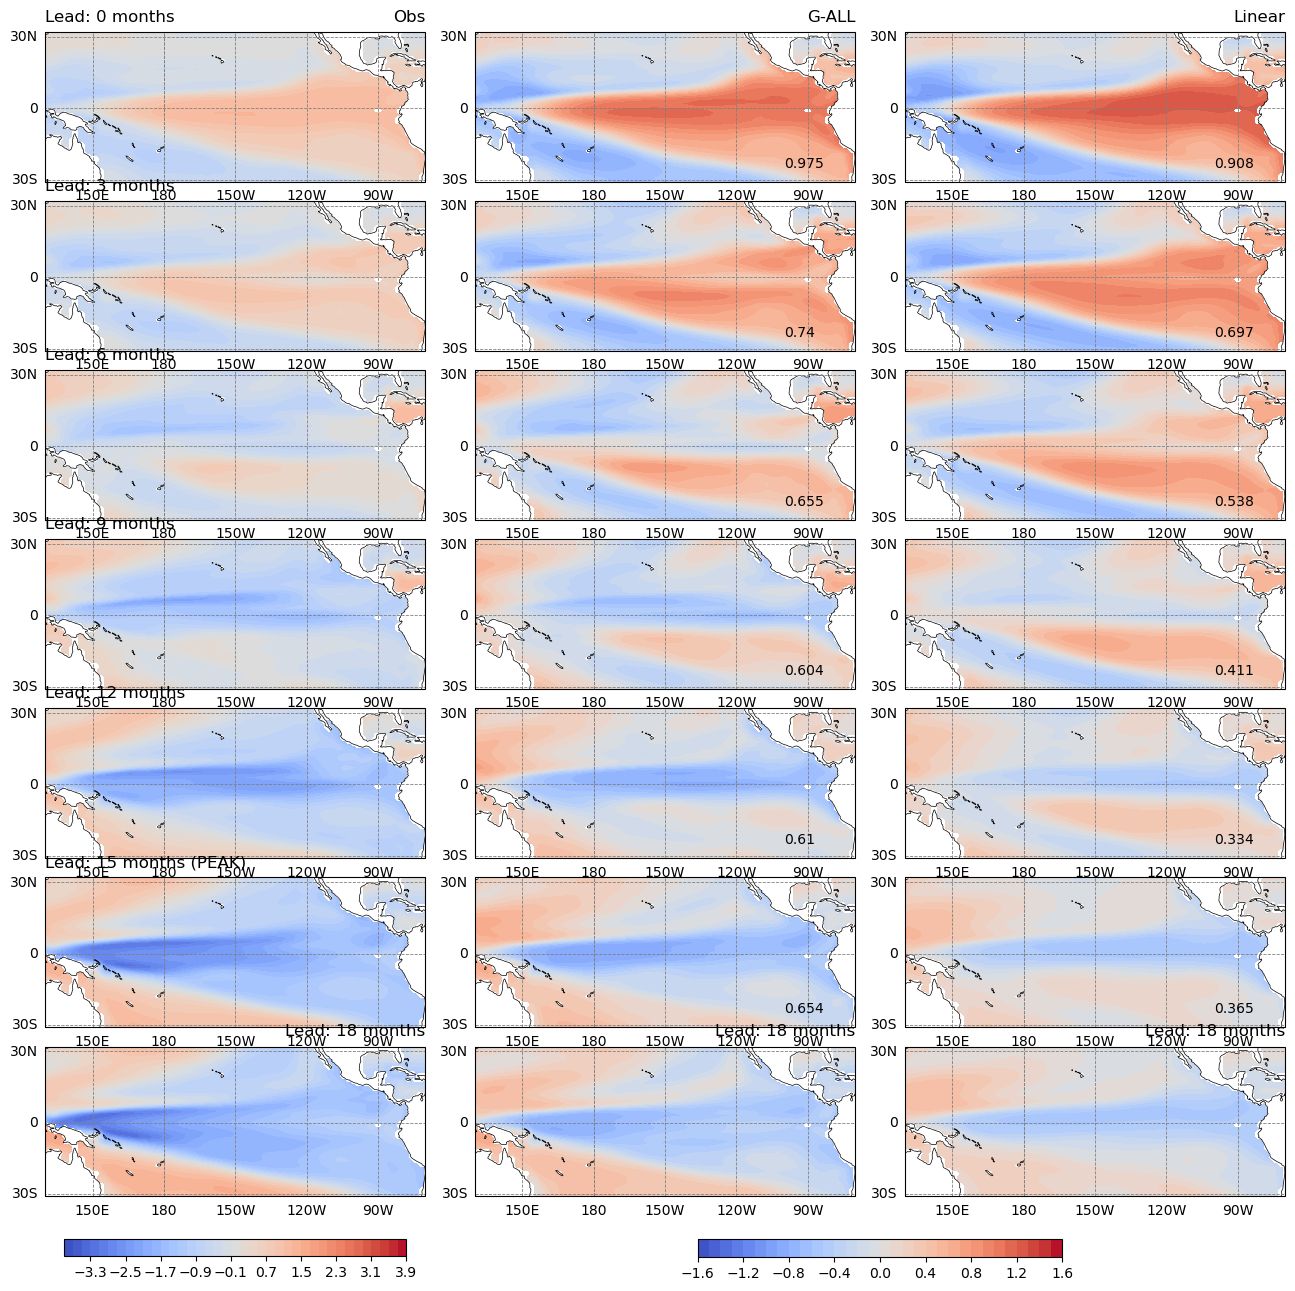

In [177]:
columns = 3
rows = 7
cont=[-3.7,3.7,0.2]
cont1=  [-1.5,1.5,0.1]       #[-1.7,1.7,0.1]

fig,ax,pro=zmap.init_figure(rows,columns,'Pacific', constrained_layout=False, figsize=(16,18.5), sharex=True, sharey=True )

axh=ax[0,0]


#Observations
handle=zmap.xmap(X_tos.A.unstack().isel(time=np.where(extreme_niña)[0][:-1]-15).mean(dim='time'),cont, pro, ax=ax[0,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'lefttitle':'Lead: 0 months', 'righttitle':'Obs','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(X_tos.A.unstack().isel(time=np.where(extreme_niña)[0][:-1]+1*3-15).mean(dim='time'),cont, pro, ax=ax[1,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'lefttitle':'Lead: 3 months', 'righttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(X_tos.A.unstack().isel(time=np.where(extreme_niña)[0][:-1]+2*3-15).mean(dim='time'),cont, pro, ax=ax[2,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'lefttitle':'Lead: 6 months', 'righttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(X_tos.A.unstack().isel(time=np.where(extreme_niña)[0][:-1]+3*3-15).mean(dim='time'),cont, pro, ax=ax[3,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'lefttitle':'Lead: 9 months', 'righttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(X_tos.A.unstack().isel(time=np.where(extreme_niña)[0][:-1]+4*3-15).mean(dim='time'),cont, pro, ax=ax[4,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'lefttitle':'Lead: 12 months' , 'righttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(X_tos.A.unstack().isel(time=np.where(extreme_niña)[0][:-1]+5*3-15).mean(dim='time'),cont, pro, ax=ax[5,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'lefttitle':'Lead: 15 months (PEAK)', 'righttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(X_tos.A.unstack().isel(time=np.where(extreme_niña)[0][:-1]+6*3-15).mean(dim='time'),cont, pro, ax=ax[6,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 18 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))


# G-ALL
handle1=zmap.xmap(average_sst_GALL.unstack().isel(time=0),cont1, pro, ax=ax[0,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'lefttitle':'', 'righttitle':'G-ALL','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_GALL.unstack().isel(time=3),cont1, pro, ax=ax[1,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_GALL.unstack().isel(time=6),cont1, pro, ax=ax[2,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_GALL.unstack().isel(time=9),cont1, pro, ax=ax[3,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_GALL.unstack().isel(time=12),cont1, pro, ax=ax[4,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_GALL.unstack().isel(time=15),cont1, pro, ax=ax[5,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_GALL.unstack().isel(time=18),cont1, pro, ax=ax[6,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 18 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))


# POLY
handle1=zmap.xmap(average_sst_POLY.unstack().isel(time=0),cont1, pro, ax=ax[0,2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'lefttitle':'', 'righttitle':'Linear','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_POLY.unstack().isel(time=3),cont1, pro, ax=ax[1,2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_POLY.unstack().isel(time=6),cont1, pro, ax=ax[2,2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_POLY.unstack().isel(time=9),cont1, pro, ax=ax[3,2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_POLY.unstack().isel(time=12),cont1, pro, ax=ax[4,2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_POLY.unstack().isel(time=15),cont1, pro, ax=ax[5,2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_POLY.unstack().isel(time=18),cont1, pro, ax=ax[6,2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 18 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))


ax[0,1].text(80,-25,np.around(np.nanmean(cstr_GALL, axis=0)[0], decimals=3))
ax[1,1].text(80,-25,np.around(np.nanmean(cstr_GALL, axis=0)[3], decimals=3))
ax[2,1].text(80,-25,np.around(np.nanmean(cstr_GALL, axis=0)[6], decimals=3))
ax[3,1].text(80,-25,np.around(np.nanmean(cstr_GALL, axis=0)[9], decimals=3))
ax[4,1].text(80,-25,np.around(np.nanmean(cstr_GALL, axis=0)[12], decimals=3))
ax[5,1].text(80,-25,np.around(np.nanmean(cstr_GALL, axis=0)[15], decimals=3))
#ax[6,1].text(80,-25,np.around(np.nanmean(cstr_GALL, axis=0)[18], decimals=3))
ax[0,2].text(80,-25,np.around(np.nanmean(cstr_POLY, axis=0)[0], decimals=3))
ax[1,2].text(80,-25,np.around(np.nanmean(cstr_POLY, axis=0)[3], decimals=3))
ax[2,2].text(80,-25,np.around(np.nanmean(cstr_POLY, axis=0)[6], decimals=3))
ax[3,2].text(80,-25,np.around(np.nanmean(cstr_POLY, axis=0)[9], decimals=3))
ax[4,2].text(80,-25,np.around(np.nanmean(cstr_POLY, axis=0)[12], decimals=3))
ax[5,2].text(80,-25,np.around(np.nanmean(cstr_POLY, axis=0)[15], decimals=3))
#ax[6,2].text(80,-25,np.around(np.nanmean(cstr_POLY, axis=0)[18], decimals=3))

axh.xaxis.set_tick_params(labelbottom=True)
zmap.changelabel(axh,fontsize=14,fontfamily='Futura',fontweight='bold')
zmap.changebox(axh,'all',linewidth=1.5)  
        
plt.subplots_adjust(wspace=0.13,hspace=0.1)
fig.colorbar(handle['filled'], ax=ax[:, 0],shrink=0.9, orientation = 'horizontal',pad=0.03)
fig.colorbar(handle1['filled'], ax=ax[:, 1:3],shrink=0.45, orientation = 'horizontal',pad=0.03)
plt.savefig('Ex2.pdf', orientation='landscape',  format='pdf')
plt.savefig('Ex2 12.jpg', orientation='landscape',  format='jpg')


plt.show()

In [181]:
average_sst_OBS.unstack().sel(lat=slice(-5,5),lon=slice(170,200)).mean(dim=('lat','lon'))

<xarray.DataArray (time: 24)>
array([ 1.0359169 ,  0.95823927,  0.82934271,  0.64643052,  0.37885514,
        0.05398172, -0.28810987, -0.63244138, -0.94988553, -1.24974053,
       -1.51917124, -1.78186571, -2.0449684 , -2.2880989 , -2.51417529,
       -2.65494756, -2.61478784, -2.48668146, -2.31679037, -2.13843652,
       -1.9715089 , -1.81556756, -1.64555906, -1.4578632 ])
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23

In [182]:
average_sst_GALL.unstack().sel(lat=slice(-5,5),lon=slice(170,200)).mean(dim=('lat','lon'))

<xarray.DataArray (time: 24)>
array([ 0.9209956 ,  0.85235012,  0.73765883,  0.59198433,  0.41814349,
        0.24971633,  0.08167177, -0.08999276, -0.25017121, -0.39216185,
       -0.51200835, -0.60310507, -0.67702045, -0.74691699, -0.7869221 ,
       -0.80504239, -0.7918935 , -0.75445024, -0.70184299, -0.64181231,
       -0.56337312, -0.48562328, -0.41984774, -0.35391947])
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23

In [183]:
average_sst_POLY.unstack().sel(lat=slice(-5,5),lon=slice(170,200)).mean(dim=('lat','lon'))

<xarray.DataArray (time: 24)>
array([ 0.94782101,  0.90635732,  0.83884544,  0.74951367,  0.64305276,
        0.52441673,  0.39858667,  0.27034392,  0.14407967,  0.0236534 ,
       -0.08769779, -0.18740311, -0.27356308, -0.34492434, -0.40083296,
       -0.44117375, -0.46630155, -0.47696928, -0.47425584, -0.45949611,
       -0.43421454, -0.4000631 , -0.35876419, -0.31205886])
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23

In [184]:
# Extract the SST variable (replace 'sst' with the appropriate variable name)
lat_range = slice(-5, 5)
sst_equator_GALL = average_sst_GALL.unstack().sel(lat=lat_range).mean(dim='lat')
sst_equator_POLY = average_sst_POLY.unstack().sel(lat=lat_range).mean(dim='lat')

average_sst_OBS=xr.zeros_like(average_sst_GALL.unstack())

for i in range(24):
    average_sst_OBS[i, :, :] = X_tos.A.unstack().isel(time=np.where(extreme_niña)[0][:-1]-15+i).mean(dim='time').data

sst_equator_OBS = average_sst_OBS.unstack().sel(lat=lat_range).mean(dim='lat')


In [179]:
obs_lim= max(sst_equator_OBS.max(), -sst_equator_OBS.min())-0.2
for_lim= max(sst_equator_GALL.max(),sst_equator_POLY.max(), -sst_equator_GALL.min(), -sst_equator_POLY.min())-0.45

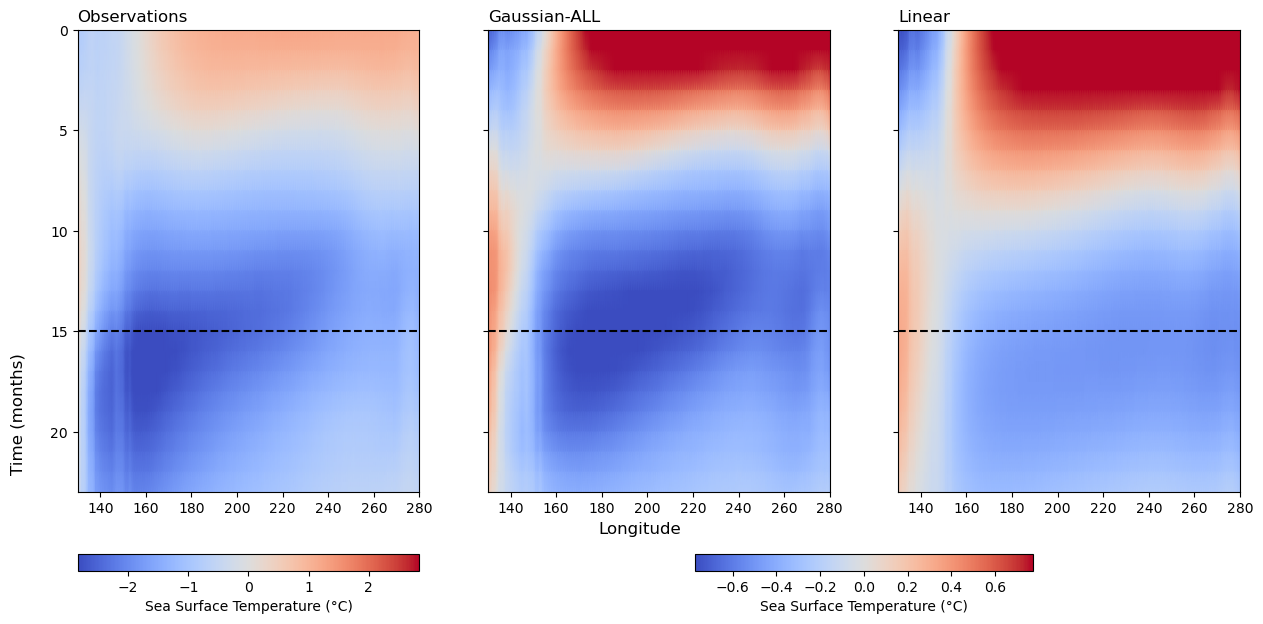

In [180]:
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs

# Extract the SST variable (replace 'sst' with the appropriate variable name)
sst = average_sst_GALL.unstack()

# Assume 'sst' has dimensions (time, latitude, longitude)
# Select a latitude range (e.g., near the equator for simplicity)
# Adjust latitude range based on your data
lat_range = slice(-10, 10)
sst_equator = sst.sel(lat=lat_range).mean(dim='lat')

# Create a Hovmöller diagram
fig, ax = plt.subplots(1, 3, figsize=(15, 8), sharex=True, sharey=True)

# Plot the data using pcolormesh
c0 = ax[0].pcolormesh(sst_equator_OBS.lon, sst_equator_OBS.time, sst_equator_OBS, cmap='coolwarm', vmin=-obs_lim, vmax=obs_lim, shading='gouraud')
c1 = ax[1].pcolormesh(sst_equator_GALL.lon, sst_equator_GALL.time, sst_equator_GALL, cmap='coolwarm', vmin=-for_lim, vmax=for_lim,shading='gouraud')
c2 = ax[2].pcolormesh(sst_equator_POLY.lon, sst_equator_POLY.time, sst_equator_POLY, cmap='coolwarm',  vmin=-for_lim, vmax=for_lim,shading='gouraud')


# Add color bars
cb0 = fig.colorbar(c0, ax=ax[0], orientation='horizontal', shrink=1, pad=0.1)
cb0.set_label('Sea Surface Temperature (°C)')

cb1 = fig.colorbar(c1, ax=ax[1:], orientation='horizontal', shrink=0.45, pad=0.1)
cb1.set_label('Sea Surface Temperature (°C)')

# Set titles for each subplot
ax[0].set_title('Observations', loc='left')
ax[1].set_title('Gaussian-ALL', loc='left')
ax[2].set_title('Linear', loc='left')

# Set labels and title
fig.text(0.5, 0.25, 'Longitude', ha='center',fontsize='large')
fig.text(0.08, 0.4, 'Time (months)', va='center', rotation='vertical',fontsize='large')

ax[0].set_xlim(130, 280)
ax[1].set_xlim(130, 280)
ax[2].set_xlim(130, 280)
ax[0].axhline(y=15, color='k', linestyle='--')
ax[1].axhline(y=15, color='k', linestyle='--')
ax[2].axhline(y=15, color='k', linestyle='--')

plt.gca().invert_yaxis()

# Adjust the date format on the y-axis if necessary
fig.autofmt_xdate()

# Show the plot
plt.show()

# Composite strong La Niña cases 12 months

In [185]:
cstr_GALL=np.zeros((np.where(extreme_niña)[0][:-1].shape[0],24))
cstr_POLY= np.zeros((np.where(extreme_niña)[0][:-1].shape[0],24))

In [186]:
## Load EOFs
PCs=np.load('Processed_data/PCs_CESM_845SST_1000SSH.npy')
EOFs=np.load('Processed_data/EOFs_CESM_845SST_1000SSH.npy')

In [187]:
periods=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
lead_times=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
leads=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]

### ALL GAUSS

In [40]:
#Select EOFs
udat_sst=EOFs[:,0:845]

In [41]:
## Compute observations NON truncated to PCs
Obs=X_tos.A.unstack()

In [42]:
### Load data

tot_for=np.zeros((20, 17, 1845, 24, 1176))

for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 200/ALLEOFs_forecast_p{n}.npy')

tot_for_unionG=np.empty((17, 1845, 24, 24000))
tot_for_unionG.fill(np.NaN)

for m in lead_times:
    for n in periods:
        tot_for_unionG[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]

In [43]:
tot_for_unionG=tot_for_unionG[(0,2,4,6,8,10,12,14,16),:,:,:]
tot_for_unionG.shape

(9, 1845, 24, 24000)

### POLY

In [44]:
#Select EOFs
udat_sst=EOFs[:,0:845]

In [45]:
## Compute observations NON truncated to PCs
Obs=X_tos.A.unstack()

In [46]:
### Load data

tot_for=np.zeros((20, 17, 30, 24, 1176))

for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 200/POLY_forecast_p{n}.npy')

tot_for_unionP=np.empty((17, 30, 24, 24000))
tot_for_unionP.fill(np.NaN)

for m in lead_times:
    for n in periods:
        tot_for_unionP[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]

In [47]:
tot_for_unionP=tot_for_unionP[(0,2,4,6,8,10,12,14,16),:,:,:]
tot_for_unionP.shape

(9, 30, 24, 24000)

### CORRELATIONS

In [188]:
# Gaussian ALL
av_for_geo_ALL = xr.DataArray(
    data=None,
    dims=["z", "time", "init"],
    coords=dict(
        z=(X_tos.A.z),
        time=range(0,24),
        init=range(0,np.where(extreme_niña)[0][:-1].shape[0]),
     ),
)

av_forALL=np.mean(tot_for_unionG, axis=0)

# Poly
av_for_geo_POLY = xr.DataArray(
    data=None,
    dims=["z", "time", "init"],
    coords=dict(
        z=(X_tos.A.z),
        time=range(0,24),
        init=range(0,np.where(extreme_niña)[0][:-1].shape[0]),
     ),
)
av_forP=np.mean(tot_for_unionP, axis=0)

In [189]:
for j in range(np.where(extreme_niña)[0][:-1].shape[0]):

    time_init=np.where(extreme_niña)[0][:-1][j]-12
    X_tos.A[:, time_init]   # Inizia a JAN, max 20841 (NOV)
    
    # Gaussian ALL
    for n in range(24):
        lead=leads[n]
        av_for_geo_array=udat_sst @ av_forALL[0:845,lead,time_init+lead]            
        av_for_geo_ALL[:,n,j]=av_for_geo_array.real
    
    # Poly
    for n in range(24):
        lead=leads[n]
        av_for_geo_array=udat_sst[:,0:20] @ av_forP[0:20,lead,time_init+lead]            
        av_for_geo_POLY[:,n,j]=av_for_geo_array.real
    
    for i in range(24):
        corr=np.corrcoef(X_tos.A.isel(time=time_init+i),av_for_geo_ALL.isel(time=i).isel(init=j).astype(float))[0,1]
        cstr_GALL[j, i]=corr
    
    for i in range(24):
        corr=np.corrcoef(X_tos.A.isel(time=time_init+i),av_for_geo_POLY.isel(time=i).isel(init=j).astype(float))[0,1]
        cstr_POLY[j, i]=corr

In [190]:
np.nanmean(cstr_GALL, axis=0)

array([0.9728439 , 0.83541931, 0.7837427 , 0.7611149 , 0.74741873,
       0.73286135, 0.71270647, 0.70054316, 0.68913419, 0.69021398,
       0.69940287, 0.71539874, 0.7217739 , 0.73267517, 0.74063903,
       0.744238  , 0.73621876, 0.72593281, 0.70498626, 0.67908128,
       0.64481157, 0.60750022, 0.57181288, 0.54193121])

In [191]:
np.nanmean(cstr_POLY, axis=0)

array([0.90590989, 0.82567736, 0.75100197, 0.69834207, 0.65754445,
       0.6204604 , 0.57886001, 0.54144265, 0.50346909, 0.4734513 ,
       0.4581516 , 0.45649879, 0.46504321, 0.48270342, 0.50137865,
       0.51079881, 0.51762182, 0.52099871, 0.51505612, 0.49978717,
       0.46970515, 0.43847567, 0.4049575 , 0.38281366])

### Plot

In [192]:
average_sst_GALL=av_for_geo_ALL.mean(dim='init')

In [193]:
average_sst_POLY=av_for_geo_POLY.mean(dim='init')

 Opening figure , 5 rows and 3 cols 

Setting Fixed Contours
 Contouring from  -3.7   to 3.7  with interval   0.2
Setting Fixed Contours
 Contouring from  -3.7   to 3.7  with interval   0.2
Setting Fixed Contours
 Contouring from  -3.7   to 3.7  with interval   0.2
Setting Fixed Contours
 Contouring from  -3.7   to 3.7  with interval   0.2
Setting Fixed Contours
 Contouring from  -3.7   to 3.7  with interval   0.2
Setting Fixed Contours
 Contouring from  -1.7   to 1.7  with interval   0.1
Setting Fixed Contours
 Contouring from  -1.7   to 1.7  with interval   0.1
Setting Fixed Contours
 Contouring from  -1.7   to 1.7  with interval   0.1
Setting Fixed Contours
 Contouring from  -1.7   to 1.7  with interval   0.1
Setting Fixed Contours
 Contouring from  -1.7   to 1.7  with interval   0.1
Setting Fixed Contours
 Contouring from  -1.7   to 1.7  with interval   0.1
Setting Fixed Contours
 Contouring from  -1.7   to 1.7  with interval   0.1
Setting Fixed Contours
 Contouring from  -1.7   to

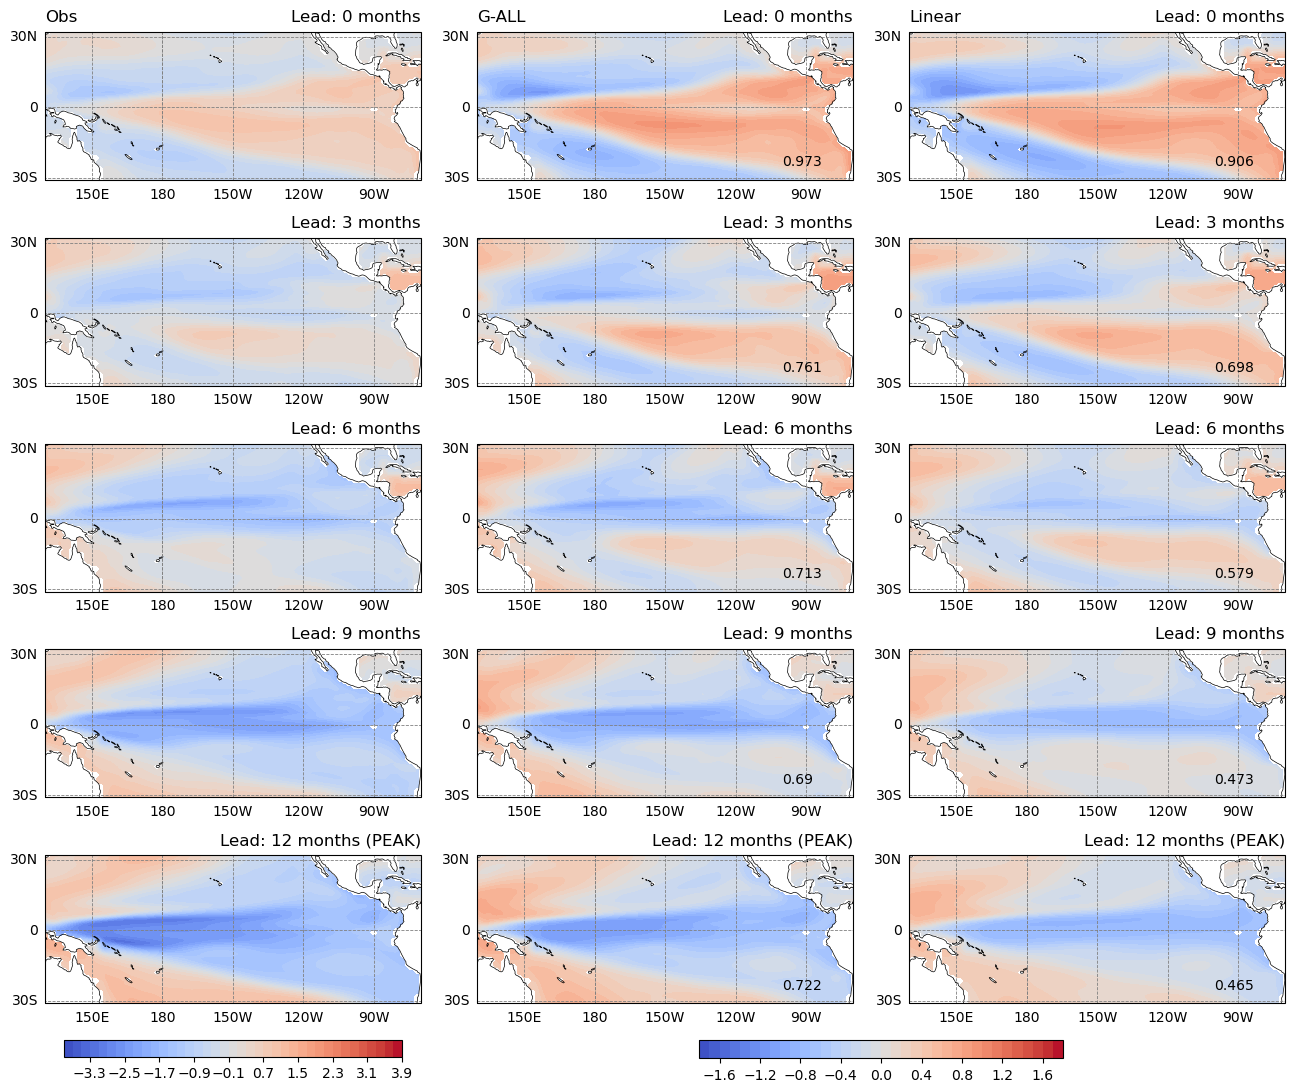

In [194]:
columns = 3
rows = 5
cont=[-3.7,3.7,0.2]
cont1=[-1.7,1.7,0.1]

fig,ax,pro=zmap.init_figure(rows,columns,'Pacific', constrained_layout=False, figsize=(16,16), sharex=True, sharey=True )

axh=ax[0,0]


#Observations
handle=zmap.xmap(X_tos.A.unstack().isel(time=np.where(extreme_niña)[0][:-1]-12).mean(dim='time'),cont, pro, ax=ax[0,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 0 months', 'lefttitle':'Obs','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(X_tos.A.unstack().isel(time=np.where(extreme_niña)[0][:-1]+1*3-12).mean(dim='time'),cont, pro, ax=ax[1,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 3 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(X_tos.A.unstack().isel(time=np.where(extreme_niña)[0][:-1]+2*3-12).mean(dim='time'),cont, pro, ax=ax[2,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 6 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(X_tos.A.unstack().isel(time=np.where(extreme_niña)[0][:-1]+3*3-12).mean(dim='time'),cont, pro, ax=ax[3,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 9 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(X_tos.A.unstack().isel(time=np.where(extreme_niña)[0][:-1]+4*3-12).mean(dim='time'),cont, pro, ax=ax[4,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 12 months (PEAK)' , 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))


# G-ALL
handle1=zmap.xmap(average_sst_GALL.unstack().isel(time=0),cont1, pro, ax=ax[0,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 0 months', 'lefttitle':'G-ALL','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_GALL.unstack().isel(time=3),cont1, pro, ax=ax[1,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 3 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_GALL.unstack().isel(time=6),cont1, pro, ax=ax[2,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 6 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_GALL.unstack().isel(time=9),cont1, pro, ax=ax[3,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 9 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_GALL.unstack().isel(time=12),cont1, pro, ax=ax[4,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 12 months (PEAK)', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))


# POLY
handle1=zmap.xmap(average_sst_POLY.unstack().isel(time=0),cont1, pro, ax=ax[0,2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 0 months', 'lefttitle':'Linear','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_POLY.unstack().isel(time=3),cont1, pro, ax=ax[1,2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 3 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_POLY.unstack().isel(time=6),cont1, pro, ax=ax[2,2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 6 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_POLY.unstack().isel(time=9),cont1, pro, ax=ax[3,2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 9 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(average_sst_POLY.unstack().isel(time=12),cont1, pro, ax=ax[4,2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 12 months (PEAK)', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))


ax[0,1].text(80,-25,np.around(np.nanmean(cstr_GALL, axis=0)[0], decimals=3))
ax[1,1].text(80,-25,np.around(np.nanmean(cstr_GALL, axis=0)[3], decimals=3))
ax[2,1].text(80,-25,np.around(np.nanmean(cstr_GALL, axis=0)[6], decimals=3))
ax[3,1].text(80,-25,np.around(np.nanmean(cstr_GALL, axis=0)[9], decimals=3))
ax[4,1].text(80,-25,np.around(np.nanmean(cstr_GALL, axis=0)[12], decimals=3))
ax[0,2].text(80,-25,np.around(np.nanmean(cstr_POLY, axis=0)[0], decimals=3))
ax[1,2].text(80,-25,np.around(np.nanmean(cstr_POLY, axis=0)[3], decimals=3))
ax[2,2].text(80,-25,np.around(np.nanmean(cstr_POLY, axis=0)[6], decimals=3))
ax[3,2].text(80,-25,np.around(np.nanmean(cstr_POLY, axis=0)[9], decimals=3))
ax[4,2].text(80,-25,np.around(np.nanmean(cstr_POLY, axis=0)[12], decimals=3))

axh.xaxis.set_tick_params(labelbottom=True)
zmap.changelabel(axh,fontsize=14,fontfamily='Futura',fontweight='bold')
zmap.changebox(axh,'all',linewidth=1.5)  
        
plt.subplots_adjust(wspace=0.15,hspace=0.1)
fig.colorbar(handle['filled'], ax=ax[:, 0],shrink=0.9, orientation = 'horizontal',pad=0.03)
fig.colorbar(handle1['filled'], ax=ax[:, 1:3],shrink=0.45, orientation = 'horizontal',pad=0.03)
#plt.savefig('Fig 12.pdf', orientation='landscape',  format='pdf')
#plt.savefig('Fig 12.jpg', orientation='landscape',  format='jpg')


plt.show()

In [196]:
average_sst_OBS.unstack().sel(lat=slice(-5,5),lon=slice(170,200)).mean(dim=('lat','lon'))

<xarray.DataArray (time: 24)>
array([ 0.64643052,  0.37885514,  0.05398172, -0.28810987, -0.63244138,
       -0.94988553, -1.24974053, -1.51917124, -1.78186571, -2.0449684 ,
       -2.2880989 , -2.51417529, -2.65494756, -2.61478784, -2.48668146,
       -2.31679037, -2.13843652, -1.9715089 , -1.81556756, -1.64555906,
       -1.4578632 , -1.24456511, -1.02791423, -0.83691998])
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23

In [197]:
average_sst_GALL.unstack().sel(lat=slice(-5,5),lon=slice(170,200)).mean(dim=('lat','lon'))

<xarray.DataArray (time: 24)>
array([ 0.56710019,  0.39519062,  0.19104858, -0.01496958, -0.22076512,
       -0.39304796, -0.5462315 , -0.67890299, -0.79213014, -0.88348006,
       -0.95564946, -1.00083559, -1.01161626, -1.00229488, -0.95048624,
       -0.8898521 , -0.80950211, -0.72222813, -0.6373711 , -0.55424639,
       -0.45995125, -0.36504335, -0.28094083, -0.19491487])
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23

In [199]:
average_sst_POLY.unstack().sel(lat=slice(-5,5),lon=slice(170,200)).mean(dim=('lat','lon'))

<xarray.DataArray (time: 24)>
array([ 0.56602176,  0.42007842,  0.26604864,  0.10969749, -0.04360582,
       -0.18906442, -0.32258494, -0.44086158, -0.54141529, -0.62259266,
       -0.68353102, -0.72409696, -0.74480561, -0.74672758, -0.73138942,
       -0.70067279, -0.65671611, -0.60182181, -0.5383711 , -0.46874781,
       -0.39527188, -0.32014295, -0.24539403, -0.17285494])
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23

In [195]:
# Extract the SST variable (replace 'sst' with the appropriate variable name)
lat_range = slice(-10, 10)
sst_equator_GALL = average_sst_GALL.unstack().sel(lat=lat_range).mean(dim='lat')
sst_equator_POLY = average_sst_POLY.unstack().sel(lat=lat_range).mean(dim='lat')

average_sst_OBS=xr.zeros_like(average_sst_GALL.unstack())

for i in range(24):
    average_sst_OBS[i, :, :] = X_tos.A.unstack().isel(time=np.where(extreme_niña)[0][:-1]-12+i).mean(dim='time').data

sst_equator_OBS = average_sst_OBS.unstack().sel(lat=lat_range).mean(dim='lat')


In [169]:
obs_lim= max(sst_equator_OBS.max(), -sst_equator_OBS.min())+0.2
for_lim= max(sst_equator_GALL.max(),sst_equator_POLY.max(), -sst_equator_GALL.min(), -sst_equator_POLY.min())+0.4

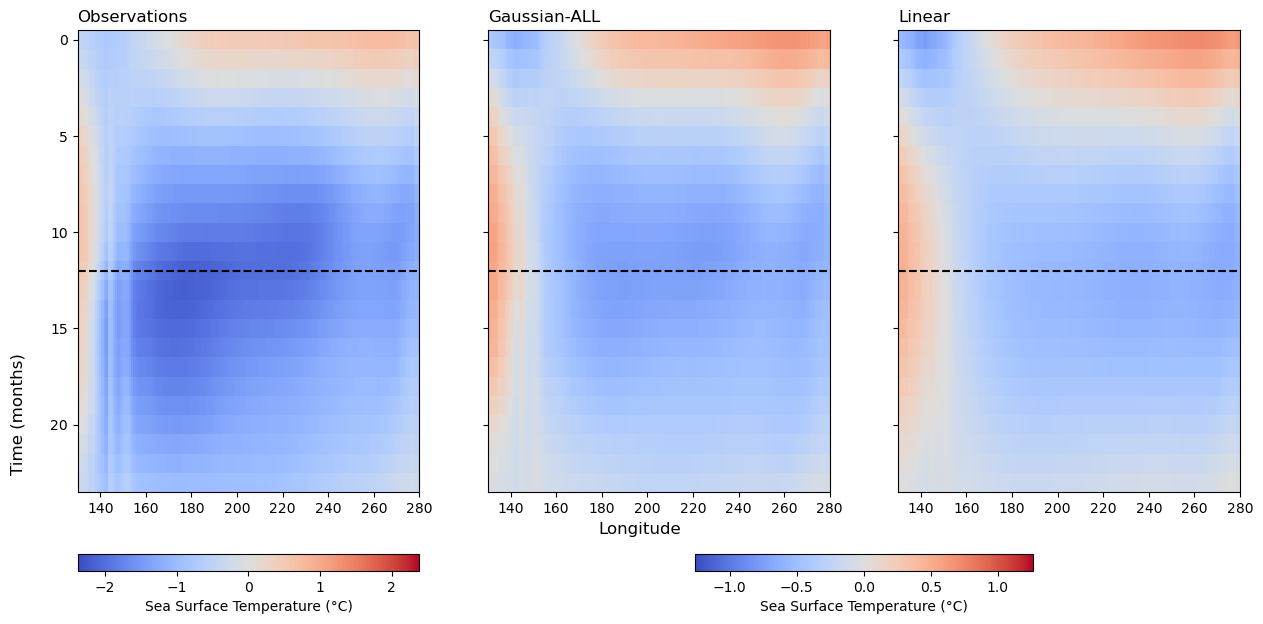

In [170]:
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs

# Extract the SST variable (replace 'sst' with the appropriate variable name)
sst = average_sst_GALL.unstack()

# Assume 'sst' has dimensions (time, latitude, longitude)
# Select a latitude range (e.g., near the equator for simplicity)
# Adjust latitude range based on your data
lat_range = slice(-10, 10)
sst_equator = sst.sel(lat=lat_range).mean(dim='lat')

# Create a Hovmöller diagram
fig, ax = plt.subplots(1, 3, figsize=(15, 8), sharex=True, sharey=True)

# Plot the data using pcolormesh
c0 = ax[0].pcolormesh(sst_equator_OBS.lon, sst_equator_OBS.time, sst_equator_OBS, cmap='coolwarm', vmin=-obs_lim, vmax=obs_lim)
c1 = ax[1].pcolormesh(sst_equator_GALL.lon, sst_equator_GALL.time, sst_equator_GALL, cmap='coolwarm', vmin=-for_lim, vmax=for_lim)
c2 = ax[2].pcolormesh(sst_equator_POLY.lon, sst_equator_POLY.time, sst_equator_POLY, cmap='coolwarm',  vmin=-for_lim, vmax=for_lim)

# Add color bars
cb0 = fig.colorbar(c0, ax=ax[0], orientation='horizontal', shrink=1, pad=0.1)
cb0.set_label('Sea Surface Temperature (°C)')

cb1 = fig.colorbar(c1, ax=ax[1:], orientation='horizontal', shrink=0.45, pad=0.1)
cb1.set_label('Sea Surface Temperature (°C)')

# Set titles for each subplot
ax[0].set_title('Observations', loc='left')
ax[1].set_title('Gaussian-ALL', loc='left')
ax[2].set_title('Linear', loc='left')

# Set labels and title
fig.text(0.5, 0.25, 'Longitude', ha='center',fontsize='large')
fig.text(0.08, 0.4, 'Time (months)', va='center', rotation='vertical',fontsize='large')

ax[0].set_xlim(130, 280)
ax[1].set_xlim(130, 280)
ax[2].set_xlim(130, 280)
ax[0].axhline(y=12, color='k', linestyle='--')
ax[1].axhline(y=12, color='k', linestyle='--')
ax[2].axhline(y=12, color='k', linestyle='--')
plt.gca().invert_yaxis()

# Adjust the date format on the y-axis if necessary
fig.autofmt_xdate()

# Show the plot
plt.show()